<a href="https://colab.research.google.com/github/Ved-Prakash2002/100-Days-of-Code/blob/main/Deaths_involving_Police_in_the_United_States.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Analyze Deaths involving Police in the United States*

***Objective:***
*To analyze the relationship between police-related deaths and socioeconomic factors (like poverty rates, education levels, and median household income) along with racial demographics in different cities across the United States. This project will demonstrate skills in data collection, cleaning, exploratory data analysis (EDA), visualization, statistical analysis, and machine learning.*


***Phase 1: Data Understanding and Cleaning***

***Understanding the Data***

In [ ]:
import pandas as pd

def review_column_names_and_descriptions(filepaths):
    results = {}
    for filepath in filepaths:
        try:
            # Attempt to read as CSV first, specifying the encoding
            df = pd.read_csv(filepath, encoding='latin-1')
        except pd.errors.ParserError:
            try:
                # Attempt to read as TSV if CSV parsing fails, specifying the encoding
                df = pd.read_csv(filepath, sep='\t', encoding='latin-1') # or 'cp1252', or other potential encodings
            except pd.errors.ParserError:
                print(f"Error: Could not parse {filepath} as either CSV or TSV.")
                continue
            except FileNotFoundError:
                print(f"Error: File not found at path {filepath}")
                continue
        except FileNotFoundError:
            print(f"Error: File not found at path {filepath}")
            continue



        results[filepath] = {
            'columns': df.columns.tolist(),
            'descriptions': {}  # Initialize an empty dictionary for descriptions
        }
    return results

filepaths = ['Deaths_by_Police_US.csv',
             'Median_Household_Income_2015.csv',
             'Pct_Over_25_Completed_High_School.csv',
             'Pct_People_Below_Poverty_Level.csv',
             'Share_of_Race_By_City.csv']
column_info = review_column_names_and_descriptions(filepaths)

# Print the results in a formatted way
for filepath, data in column_info.items():
  print(f"File: {filepath}")
  print(f"  Columns: {data['columns']}")
  if data['descriptions']:
    print("  Column Descriptions:")
    for col, desc in data['descriptions'].items():
      print(f"    {col}: {desc}")
  print("-" * 20)

File: Deaths_by_Police_US.csv
  Columns: ['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera']
--------------------
File: Median_Household_Income_2015.csv
  Columns: ['Geographic Area', 'City', 'Median Income']
--------------------
File: Pct_Over_25_Completed_High_School.csv
  Columns: ['Geographic Area', 'City', 'percent_completed_hs']
--------------------
File: Pct_People_Below_Poverty_Level.csv
  Columns: ['Geographic Area', 'City', 'poverty_rate']
--------------------
File: Share_of_Race_By_City.csv
  Columns: ['Geographic area', 'City', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']
--------------------


***Data Cleaning***

In [ ]:
def standardize_city_state(df, city_col, state_col):
    # Make a copy to avoid altering the original DataFrame
    df_copy = df.copy()

    # Normalize column names to lowercase for consistency
    df_copy.columns = df_copy.columns.str.lower()

    # Check and standardize 'City' column
    if city_col.lower() in df_copy.columns:
        df_copy[city_col.lower()] = df_copy[city_col.lower()].str.strip().str.lower()
        df_copy[city_col.lower()] = df_copy[city_col.lower()].str.title()

    # Check and standardize 'State' column
    # Check if state_col is not None before attempting to use lower()
    if state_col is not None and state_col.lower() in df_copy.columns:
        df_copy[state_col.lower()] = df_copy[state_col.lower()].str.strip().str.lower()
        df_copy[state_col.lower()] = df_copy[state_col.lower()].str.upper()

    return df_copy

for filepath in filepaths:
    try:
        df = pd.read_csv(filepath, encoding='latin-1')
    except FileNotFoundError:
        print(f"Error: File not found at path {filepath}")
        continue

    if 'City' in df.columns or 'State' in df.columns or 'city' in df.columns or 'state' in df.columns:
        df_standardized = standardize_city_state(df, 'City', 'State')

        print(f"Standardized data for {filepath}:")
        # Check for standardized 'City' and 'State' columns before printing
        city_col = 'city' if 'city' in df_standardized.columns else 'City'
        state_col = 'state' if 'state' in df_standardized.columns else 'State'

        if city_col in df_standardized.columns and state_col in df_standardized.columns:
            print(df_standardized[[city_col, state_col]].head())
        elif city_col in df_standardized.columns:
            print(df_standardized[[city_col]].head())
        else:
            print(df_standardized[[state_col]].head())
    else:
        print(f"'City' and 'State' columns not found in {filepath}. Skipping standardization.")


Standardized data for Deaths_by_Police_US.csv:
            city state
0        Shelton    WA
1          Aloha    OR
2        Wichita    KS
3  San Francisco    CA
4          Evans    CO
Standardized data for Median_Household_Income_2015.csv:
              city
0       Abanda Cdp
1   Abbeville City
2  Adamsville City
3     Addison Town
4       Akron Town
Standardized data for Pct_Over_25_Completed_High_School.csv:
              city
0       Abanda Cdp
1   Abbeville City
2  Adamsville City
3     Addison Town
4       Akron Town
Standardized data for Pct_People_Below_Poverty_Level.csv:
              city
0       Abanda Cdp
1   Abbeville City
2  Adamsville City
3     Addison Town
4       Akron Town
Standardized data for Share_of_Race_By_City.csv:
              city
0       Abanda Cdp
1   Abbeville City
2  Adamsville City
3     Addison Town
4       Akron Town


In [ ]:
import numpy as np

def handle_missing_values(df, threshold=0.5):
  df_copy = df.copy()
  missing_counts = df_copy.isnull().sum()
  total_rows = len(df_copy)
  missing_proportions = missing_counts / total_rows

  # Identify columns to drop
  columns_to_drop = missing_proportions[missing_proportions > threshold].index.tolist()
  df_copy = df_copy.drop(columns=columns_to_drop)
  print(f"Dropped columns due to high missing value proportion (> {threshold}): {columns_to_drop}")

  # Impute remaining columns
  for col in df_copy.columns:
    if df_copy[col].isnull().any():
      if pd.api.types.is_numeric_dtype(df_copy[col]):
        df_copy[col].fillna(df_copy[col].median(), inplace=True)
        print(f"Imputed column '{col}' with median value.")
      else:
        df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        print(f"Imputed column '{col}' with mode value.")

  return df_copy

for filepath in filepaths:
  try:
    df = pd.read_csv(filepath, encoding='latin-1')
    print(f"\nHandling missing values for: {filepath}")
    df_cleaned = handle_missing_values(df)
    print(f"Missing values in {filepath} after processing:\n{df_cleaned.isnull().sum()}")
  except FileNotFoundError:
      print(f"Error: File not found at path {filepath}")
      continue


Handling missing values for: Deaths_by_Police_US.csv
Dropped columns due to high missing value proportion (> 0.5): []
Imputed column 'armed' with mode value.
Imputed column 'age' with median value.
Imputed column 'race' with mode value.
Imputed column 'flee' with mode value.
Missing values in Deaths_by_Police_US.csv after processing:
id                         0
name                       0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
dtype: int64

Handling missing values for: Median_Household_Income_2015.csv
Dropped columns due to high missing value proportion (> 0.5): []
Imputed column 'Median Income' with mode value.
Missing values in Median_Household_Income_2015.csv after processing:

<ipython-input-3-8717d8055d69>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
<ipython-input-3-8717d8055d69>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',


Handling missing values for: Share_of_Race_By_City.csv
Dropped columns due to high missing value proportion (> 0.5): []
Missing values in Share_of_Race_By_City.csv after processing:
Geographic area          0
City                     0
share_white              0
share_black              0
share_native_american    0
share_asian              0
share_hispanic           0
dtype: int64


In [ ]:
df = pd.read_csv('Deaths_by_Police_US.csv', encoding='latin-1')
pd.to_datetime(df['date'], format='%d/%m/%y', errors='coerce')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [ ]:
def remove_outliers(df, columns, method='iqr', threshold=1.5):
    df_cleaned = df.copy()
    for col in columns:
        if col in df_cleaned.columns:
            # Check if the column is numeric before proceeding
            if pd.api.types.is_numeric_dtype(df_cleaned[col]):
                if method == 'iqr':
                    Q1 = df_cleaned[col].quantile(0.25)
                    Q3 = df_cleaned[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - threshold * IQR
                    upper_bound = Q3 + threshold * IQR
                    df_cleaned = df_cleaned[~((df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound))]
                elif method == 'zscore':
                    z_scores = np.abs((df_cleaned[col] - df_cleaned[col].mean()) / df_cleaned[col].std())
                    df_cleaned = df_cleaned[z_scores < threshold]
                else:
                    print(f"Invalid outlier detection method: {method}")
        else:
            print(f"Column '{col}' not found in the DataFrame.")
    return df_cleaned

# Filepaths and column mappings
filepaths_for_outlier = [
    ('Deaths_by_Police_US.csv', ['age']),
    ('Median_Household_Income_2015.csv', ['Median Income']),
    ('Pct_People_Below_Poverty_Level.csv', ['poverty_rate']),
]

# Process each file
for filepath, columns in filepaths_for_outlier:
    try:
        df = pd.read_csv(filepath, encoding='latin-1')
        # Check if specified columns exist
        valid_columns = [col for col in columns if col in df.columns]
        if valid_columns:
            df_no_outliers = remove_outliers(df, valid_columns, method='iqr')
            print(f"Processed {filepath}:")
            print(df_no_outliers.head())
        else:
            print(f"None of the specified columns {columns} found in {filepath}.")
    except FileNotFoundError:
        print(f"File '{filepath}' not found.")


Processed Deaths_by_Police_US.csv:
   id                name      date   manner_of_death       armed   age  \
0   3          Tim Elliot  02/01/15              shot         gun  53.0   
1   4    Lewis Lee Lembke  02/01/15              shot         gun  47.0   
2   5  John Paul Quintero  03/01/15  shot and Tasered     unarmed  23.0   
3   8     Matthew Hoffman  04/01/15              shot  toy weapon  32.0   
4   9   Michael Rodriguez  04/01/15              shot    nail gun  39.0   

  gender race           city state  signs_of_mental_illness threat_level  \
0      M    A        Shelton    WA                     True       attack   
1      M    W          Aloha    OR                    False       attack   
2      M    H        Wichita    KS                    False        other   
3      M    W  San Francisco    CA                     True       attack   
4      M    H          Evans    CO                    False       attack   

          flee  body_camera  
0  Not fleeing        False

***Merge datasets***

In [ ]:
import pandas as pd

def merge_datasets(filepaths, city_col='City'):
    merged_df = None

    for i, filepath in enumerate(filepaths):
        # Load the dataset
        df = pd.read_csv(filepath, encoding='latin-1')

        # Standardize city column
        df = standardize_city_state(df, city_col=city_col, state_col=None)

        # Ensure the city column is standardized
        city_col_lower = city_col.lower()

        if city_col_lower in df.columns:
            # If first dataset, initialize the merged DataFrame
            if merged_df is None:
                merged_df = df
            else:
                # Rename potentially conflicting columns before merging
                common_cols = list(set(merged_df.columns) & set(df.columns) - {city_col_lower})
                for col in common_cols:
                    df = df.rename(columns={col: f"{col}_{i}"})  # Rename in the current DataFrame

                # Merge with the current dataset using 'City'
                merged_df = pd.merge(
                    merged_df,
                    df,
                    on=[city_col_lower],
                    how='outer'
                )
        else:
            print(f"'{city_col}' column not found in {filepath}. Skipping.")

    return merged_df

# Filepaths for datasets
filepaths = [
    'Deaths_by_Police_US.csv',
    'Median_Household_Income_2015.csv',
    'Pct_Over_25_Completed_High_School.csv',
    'Pct_People_Below_Poverty_Level.csv',
    'Share_of_Race_By_City.csv',
]

# Merge datasets using only the 'City' column
merged_data = merge_datasets(filepaths)

# Display results
if merged_data is not None:
    print("Merged Dataset:")
    print(merged_data.head())
    print(merged_data.columns)
else:
    print("No datasets could be merged.")


Merged Dataset:
       id                   name      date manner_of_death armed   age gender  \
0     NaN                    NaN       NaN             NaN   NaN   NaN    NaN   
1     NaN                    NaN       NaN             NaN   NaN   NaN    NaN   
2     NaN                    NaN       NaN             NaN   NaN   NaN    NaN   
3  2624.0  Charles Darnell Baker  02/06/17            shot   gun  29.0      M   
4     NaN                    NaN       NaN             NaN   NaN   NaN    NaN   

  race                                city state  ... geographic area_2  \
0  NaN      Aaronsburg Cdp (Centre County)   NaN  ...                PA   
1  NaN  Aaronsburg Cdp (Washington County)   NaN  ...                PA   
2  NaN                          Abanda Cdp   NaN  ...                AL   
3    B                           Abbeville    AL  ...               NaN   
4  NaN                      Abbeville City   NaN  ...                AL   

  percent_completed_hs geographic area_3 pover

In [ ]:
merged_data.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,geographic area_2,percent_completed_hs,geographic area_3,poverty_rate,geographic area_4,share_white,share_black,share_native_american,share_asian,share_hispanic
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaronsburg Cdp (Centre County),NaN,...,PA,92.2,PA,8.5,PA,99.2,0.2,0,0,0.5
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaronsburg Cdp (Washington County),NaN,...,PA,83.1,PA,29.5,PA,90.7,1.5,1.2,0,1.5
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abanda Cdp,NaN,...,AL,21.2,AL,78.8,AL,67.2,30.2,0,0,1.6
3,2624.0,Charles Darnell Baker,02/06/17,shot,gun,29.0,M,B,Abbeville,AL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abbeville City,NaN,...,AL,69.1,AL,29.1,AL,54.4,41.4,0.1,1,3.1


In [ ]:
columns_to_drop = ['state', 'geographic area_2', 'geographic area_3', 'geographic area_4']
for col in columns_to_drop:
    if col in merged_data.columns:
        merged_data = merged_data.drop(col, axis=1)
    else:
        print(f"Column '{col}' not found in the DataFrame. Skipping.")

merged_data.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,signs_of_mental_illness,...,body_camera,geographic area,median income,percent_completed_hs,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaronsburg Cdp (Centre County),NaN,...,NaN,PA,52708,92.2,8.5,99.2,0.2,0,0,0.5
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaronsburg Cdp (Washington County),NaN,...,NaN,PA,60268,83.1,29.5,90.7,1.5,1.2,0,1.5
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abanda Cdp,NaN,...,NaN,AL,11207,21.2,78.8,67.2,30.2,0,0,1.6
3,2624.0,Charles Darnell Baker,02/06/17,shot,gun,29.0,M,B,Abbeville,False,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abbeville City,NaN,...,NaN,AL,25615,69.1,29.1,54.4,41.4,0.1,1,3.1


In [ ]:
# Check if the columns exist before operations

cols = merged_data.columns.tolist()
cols.insert(cols.index('city') + 1, cols.pop(cols.index('geographic area')))
merged_data = merged_data[cols]

# Rename 'geographic_area_2' to 'state'
merged_data = merged_data.rename(columns={'geographic area': 'state'})

merged_data.head()


,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,flee,body_camera,median income,percent_completed_hs,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaronsburg Cdp (Centre County),PA,...,NaN,NaN,52708,92.2,8.5,99.2,0.2,0,0,0.5
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaronsburg Cdp (Washington County),PA,...,NaN,NaN,60268,83.1,29.5,90.7,1.5,1.2,0,1.5
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abanda Cdp,AL,...,NaN,NaN,11207,21.2,78.8,67.2,30.2,0,0,1.6
3,2624.0,Charles Darnell Baker,02/06/17,shot,gun,29.0,M,B,Abbeville,NaN,...,Not fleeing,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abbeville City,AL,...,NaN,NaN,25615,69.1,29.1,54.4,41.4,0.1,1,3.1


***Phase 2: Exploratory Data Analysis***

***Descriptive Statistics***

In [ ]:
columns_for_stats = ['age', 'Median Income', 'percent_completed_hs', 'poverty_rate',
                     'share_white', 'share_black', 'share_native_american',
                     'share_asian', 'share_hispanic']

# Check if columns exists
valid_columns = [col for col in columns_for_stats if col in merged_data.columns]

# Check if columns exists
valid_columns = [col for col in columns_for_stats if col in merged_data.columns]

if valid_columns:
  # Convert relevant columns to numeric
  for col in valid_columns:
    if merged_data[col].dtype == 'object':  # Check if column is of object type (likely string)
      try:
        merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')
      except ValueError as e:
        print(f"Error converting column '{col}' to numeric: {e}")
        # Handle the error, e.g., drop the column or impute with a suitable value

  summary_stats = merged_data[valid_columns].describe()
  print(summary_stats)

  # Calculate and print median for each column (describe doesn't provide median)
  medians = merged_data[valid_columns].median()
  print("\nMedians:\n", medians)
else:
    print("Some of the specified columns were not found in the DataFrame.")

                age  percent_completed_hs   poverty_rate    share_white  \
count  15361.000000          968077.00000  968080.000000  969839.000000   
mean      24.028774              85.45678      18.241367      82.296156   
std       11.757570               8.60783      10.493660      20.210596   
min        6.000000               0.00000       0.000000       0.000000   
25%       18.000000              80.80000      10.600000      74.700000   
50%       18.000000              86.60000      17.100000      91.400000   
75%       29.000000              91.60000      24.600000      96.300000   
max       91.000000             100.00000     100.000000     100.000000   

         share_black  share_native_american    share_asian  share_hispanic  
count  969839.000000          969839.000000  969839.000000   969839.000000  
mean       10.494183               1.010322       1.351169        6.661237  
std        18.270374               4.984674       2.928505       11.054845  
min         0.00

In [ ]:
# Load the dataframe
df = pd.read_csv('Deaths_by_Police_US.csv', encoding='latin-1')

# Specify the categorical columns
categorical_cols = ['manner_of_death', 'armed', 'gender', 'race', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera']

# Calculate distributions for each specified column
for col in categorical_cols:
    if col in df.columns:
        print(f"Distribution of '{col}':")
        print(df[col].value_counts(normalize=True) * 100)  # Normalize to percentages
        print("-" * 20)
    else:
        print(f"Column '{col}' not found in the DataFrame.")

Distribution of 'manner_of_death':
manner_of_death
shot                93.21499
shot and Tasered     6.78501
Name: proportion, dtype: float64
--------------------
Distribution of 'armed':
armed
gun             55.344418
knife           14.766429
vehicle          7.007126
unarmed          6.769596
undetermined     4.631829
                  ...    
hand torch       0.039588
garden tool      0.039588
pole             0.039588
pick-axe         0.039588
pen              0.039588
Name: proportion, Length: 68, dtype: float64
--------------------
Distribution of 'gender':
gender
M    95.779093
F     4.220907
Name: proportion, dtype: float64
--------------------
Distribution of 'race':
race
W    51.324786
B    26.410256
H    18.076923
A     1.666667
N     1.324786
O     1.196581
Name: proportion, dtype: float64
--------------------
Distribution of 'signs_of_mental_illness':
signs_of_mental_illness
False    75.029586
True     24.970414
Name: proportion, dtype: float64
--------------------
Distr

***Visualization***

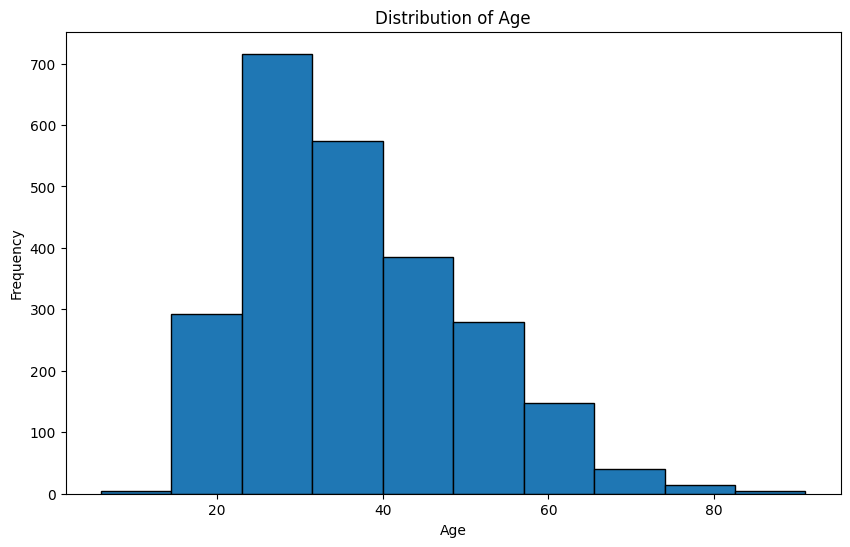

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv('Deaths_by_Police_US.csv', encoding='latin-1')

df['age'] = pd.to_numeric(df['age'], errors='coerce')
df = df.dropna(subset=['age'])

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.hist(df['age'], bins=10, edgecolor='black')  # Customize bins and edgecolor
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()


In [ ]:
extracted_data = merged_data[['name', 'city', 'poverty_rate']]

for col in extracted_data.columns:
    extracted_data = extracted_data.dropna(subset=[col])

extracted_data.head()

,name,city,poverty_rate
34617,Tremaine Dantzler,Atlantic City,15.3
34618,Jerome Damon,Atlantic City,15.3
87151,Jacob Haglund,Bay City,15.2
98380,John Marcell Allen,Boulder City,23.1
98381,John Marcell Allen,Boulder City,23.1


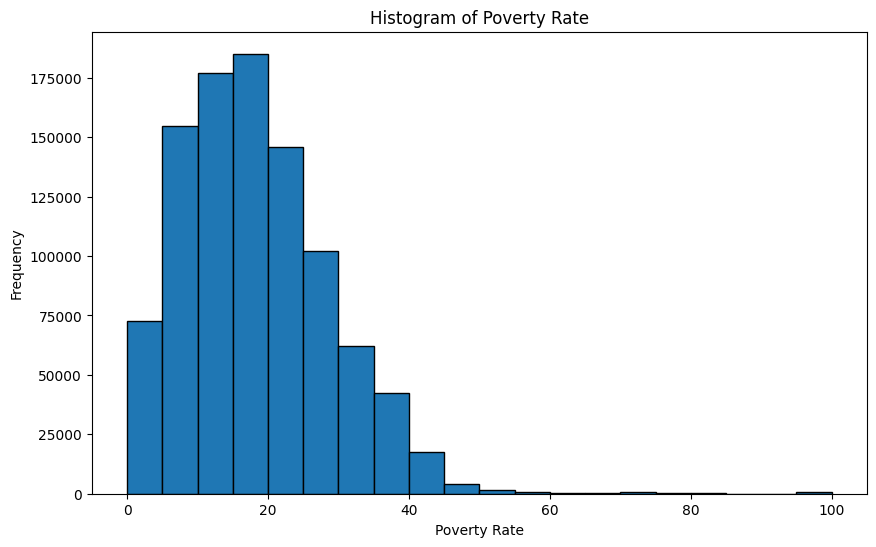

In [ ]:
merged_data['poverty_rate'] = pd.to_numeric(merged_data['poverty_rate'], errors='coerce')
plt.figure(figsize=(10, 6))
plt.hist(merged_data['poverty_rate'], bins=20, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Poverty Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Poverty Rate')
plt.show()

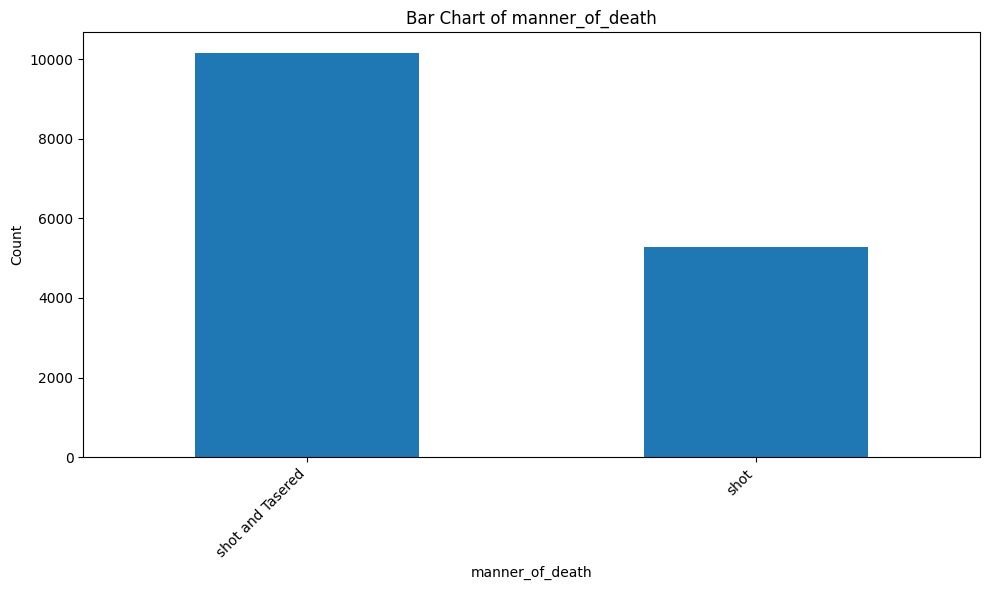

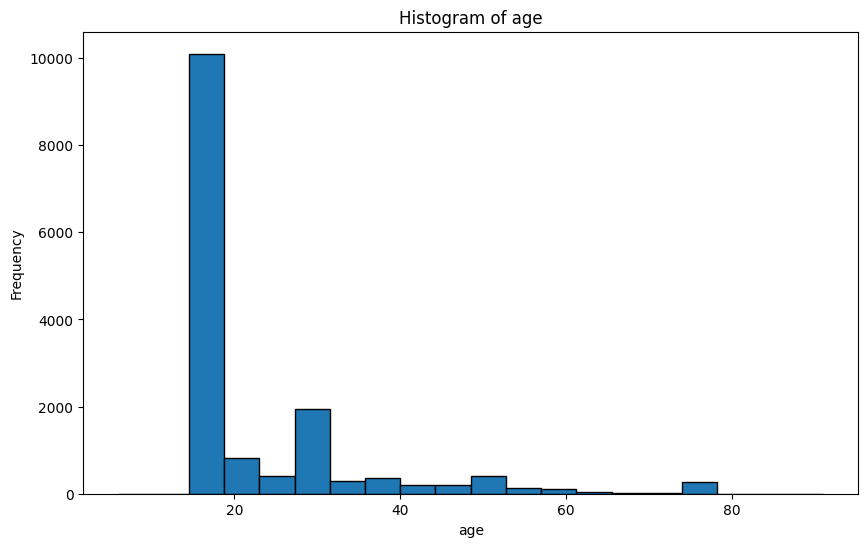

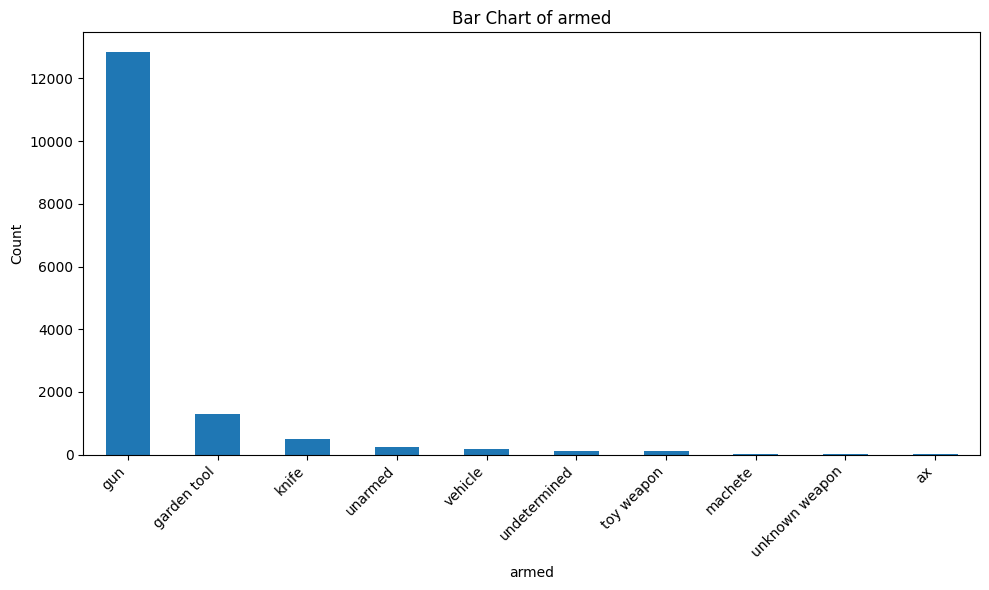

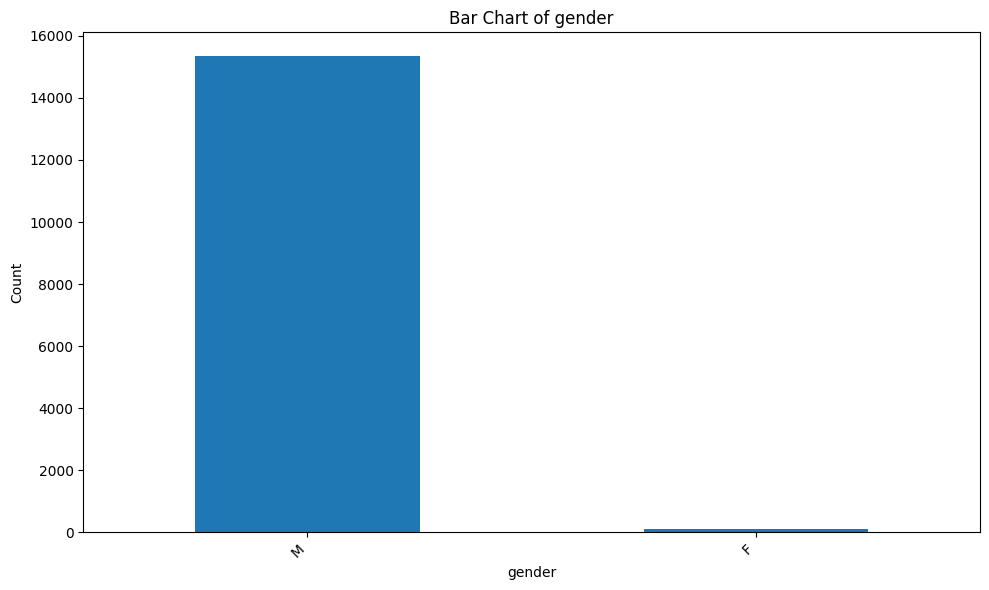

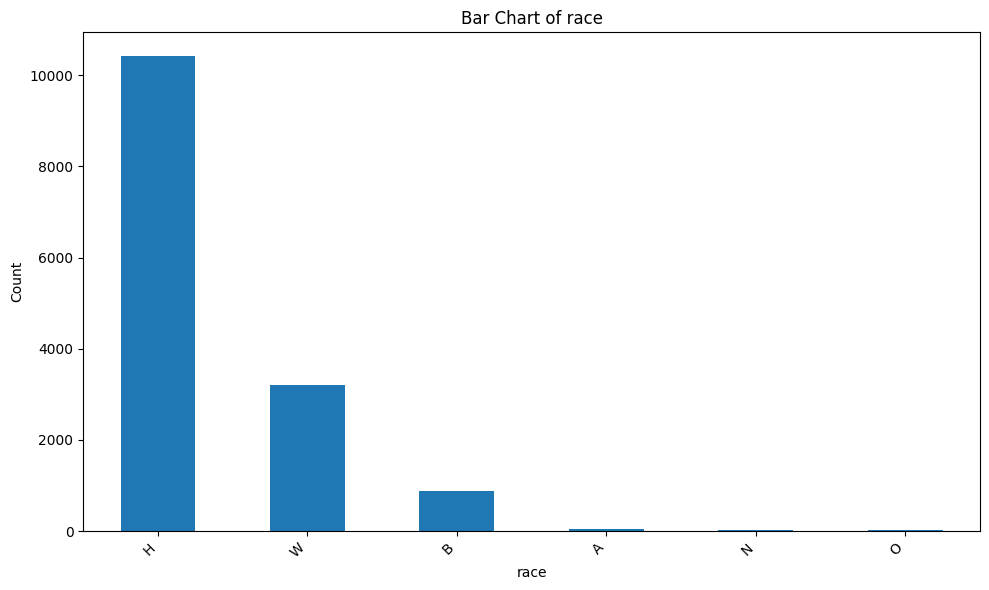

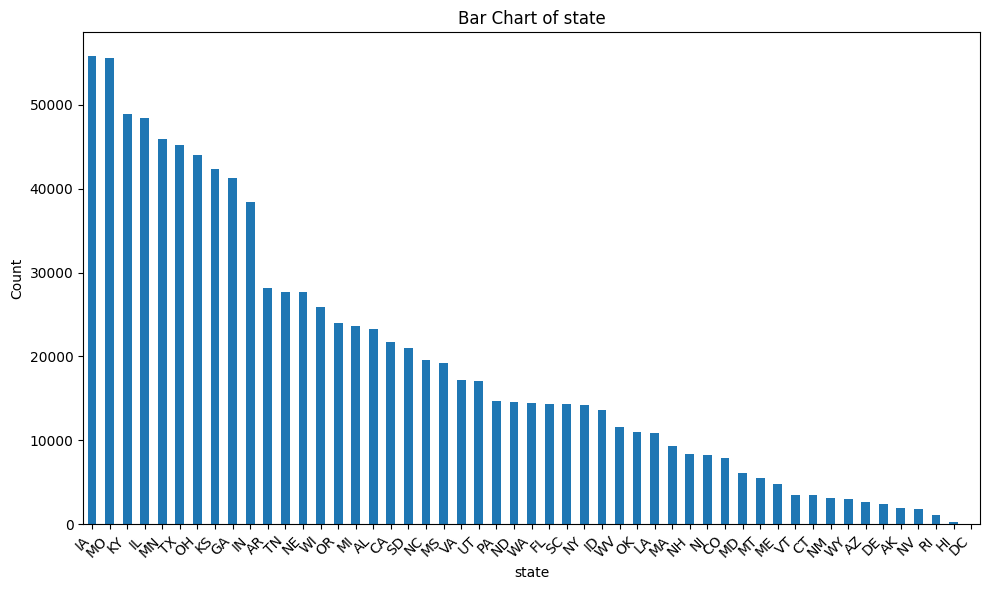

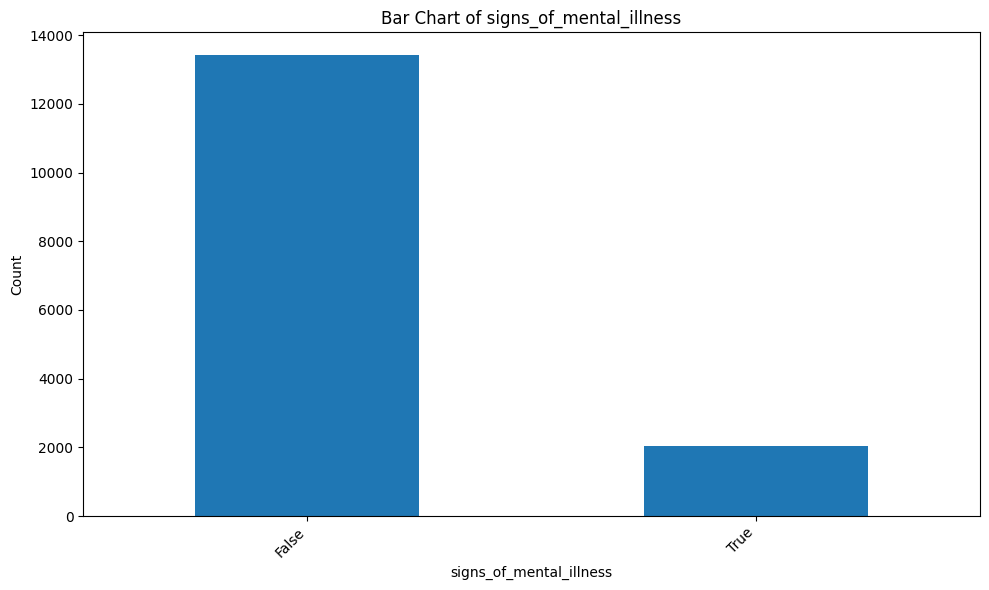

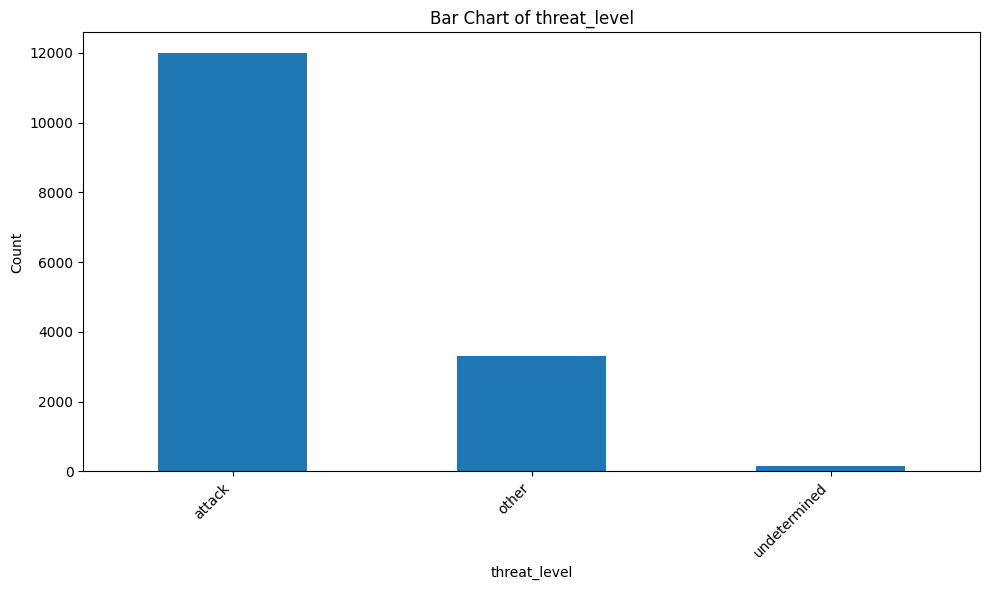

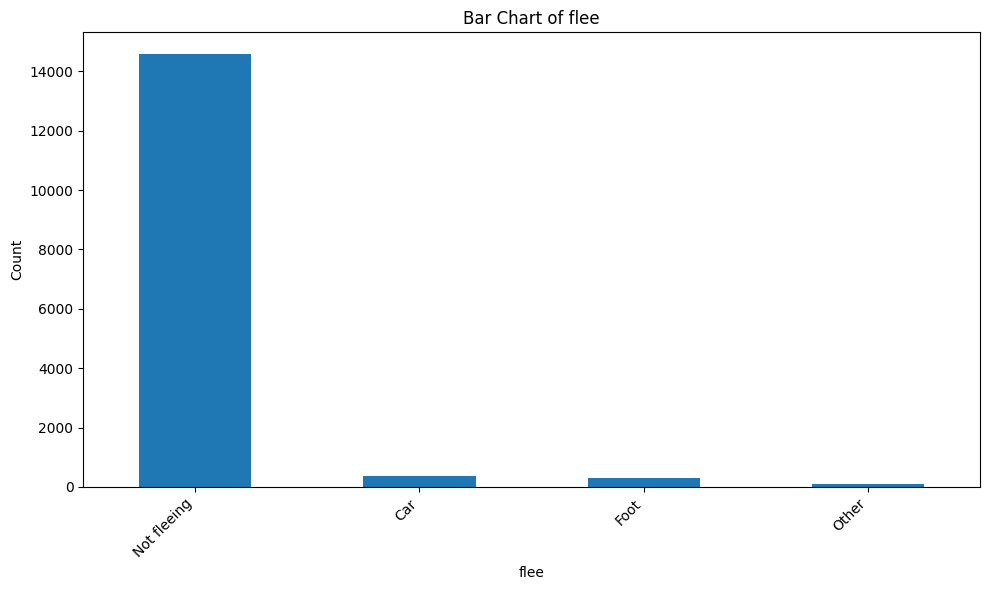

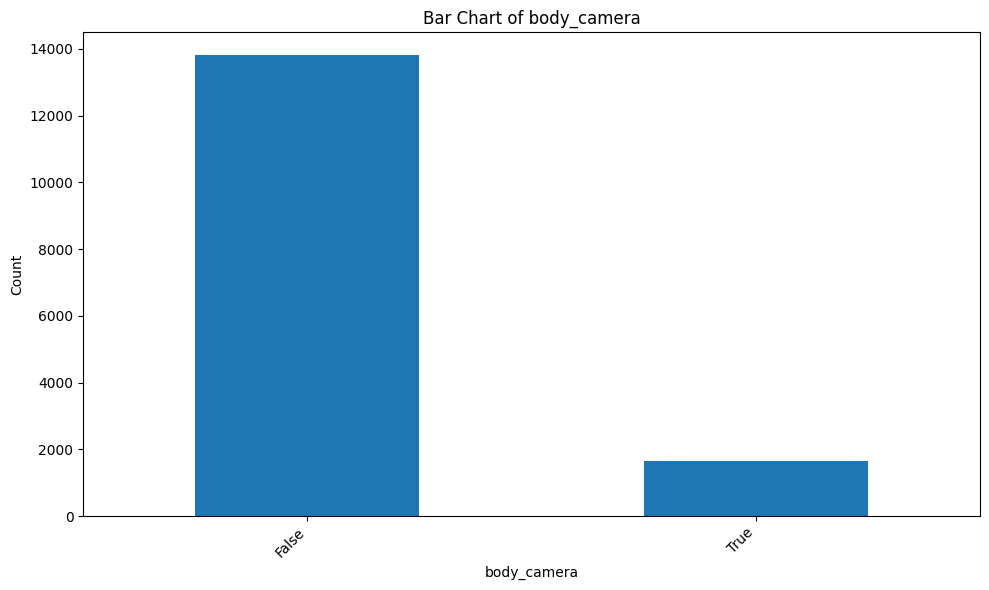

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

columns_to_plot = ['manner_of_death', 'age', 'armed', 'gender', 'race', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera']

for column in columns_to_plot:
    if column in merged_data.columns:
        # Handle potential errors during plotting
        try:
            if pd.api.types.is_numeric_dtype(merged_data[column]):
                # Numerical column
                plt.figure(figsize=(10, 6))
                plt.hist(merged_data[column].dropna(), bins=20, edgecolor='black')
                plt.xlabel(column)
                plt.ylabel('Frequency')
                plt.title(f'Histogram of {column}')
                plt.show()
            else:
                # Categorical column
                value_counts = merged_data[column].value_counts()

                # For 'armed', only plot the top 10 most frequent values
                if column == 'armed':
                    value_counts = value_counts.head(10)

                plt.figure(figsize=(10, 6))
                value_counts.plot(kind='bar')
                plt.xlabel(column)
                plt.ylabel('Count')
                plt.title(f'Bar Chart of {column}')
                plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
                plt.tight_layout()  # Adjust layout to prevent labels from overlapping
                plt.show()

        except Exception as e:
            print(f"Error plotting {column}: {e}")
    else:
        print(f"Column '{column}' not found in the DataFrame.")


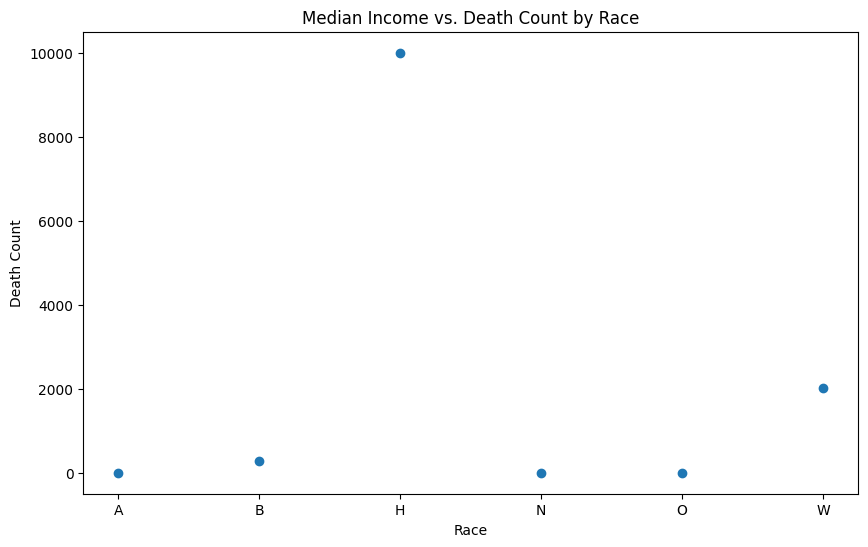

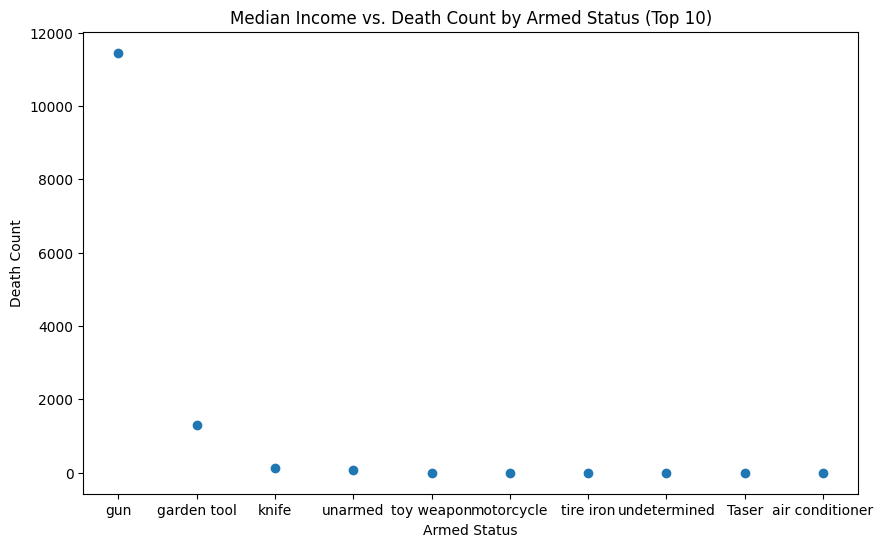

In [ ]:
def create_scatter_plot(x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.scatter(x_col, y_col)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Median Income vs. Death Count by Race
try:
    race_counts = merged_data.groupby('race')['median income'].count()
    create_scatter_plot(
        race_counts.index,
        race_counts.values,
        'Median Income vs. Death Count by Race',
        'Race',
        'Death Count'
    )
except KeyError as e:
    print(f"Error creating plot for race: {e}")

# Median Income vs. Death Count by Armed Status (Top 10 Only)
try:
    # Group by 'armed' and count occurrences
    armed_counts = merged_data.groupby('armed')['median income'].count()

    # Sort by count and select the top 10 most frequent
    armed_counts = armed_counts.nlargest(10)

    # Create scatter plot
    create_scatter_plot(
        armed_counts.index,
        armed_counts.values,
        'Median Income vs. Death Count by Armed Status (Top 10)',
        'Armed Status',
        'Death Count'
    )
except KeyError as e:
    print(f"Error creating plot for armed status: {e}")



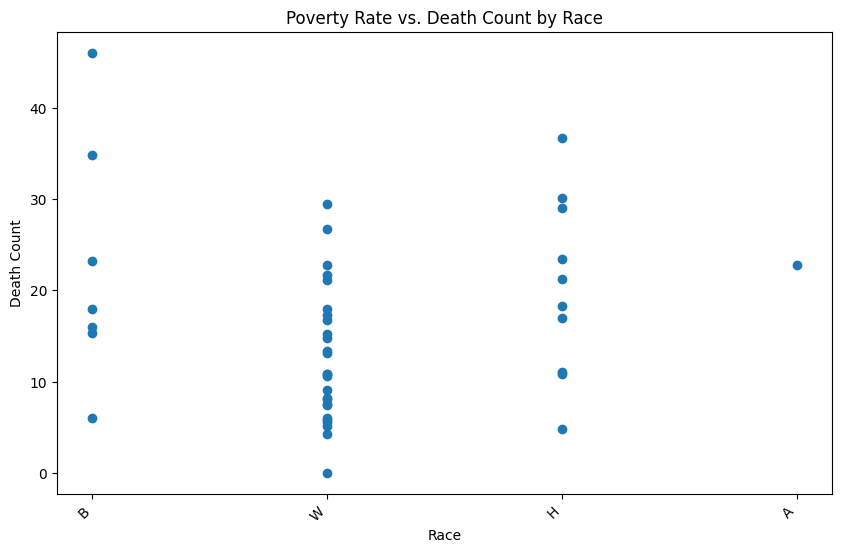

In [ ]:
# Function to create scatter plots
def create_scatter_plot(df, x_col, y_col, title, xlabel, ylabel):
    # Drop rows where x_col or y_col has NaN values
    df = df.dropna(subset=[x_col, y_col])

    plt.figure(figsize=(10, 6))
    # Ensure x-axis data is of type string
    x_data = df[x_col].astype(str)
    # Ensure y-axis data is numeric
    y_data = pd.to_numeric(df[y_col], errors='coerce').fillna(0)
    plt.scatter(x_data, y_data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.show()

try:
    # Filter out duplicates to avoid multiple entries for the same race
    race_poverty_data = merged_data[['race', 'poverty_rate']].drop_duplicates()

    # Remove rows where 'race' or 'poverty_rate' is NaN
    race_poverty_data = race_poverty_data.dropna(subset=['race', 'poverty_rate'])

    # Create the scatter plot
    create_scatter_plot(
        race_poverty_data,
        'race',
        'poverty_rate',
        'Poverty Rate vs. Death Count by Race',
        'Race',
        'Death Count'
    )
except KeyError as e:
    print(f"Error creating plot: {e}")


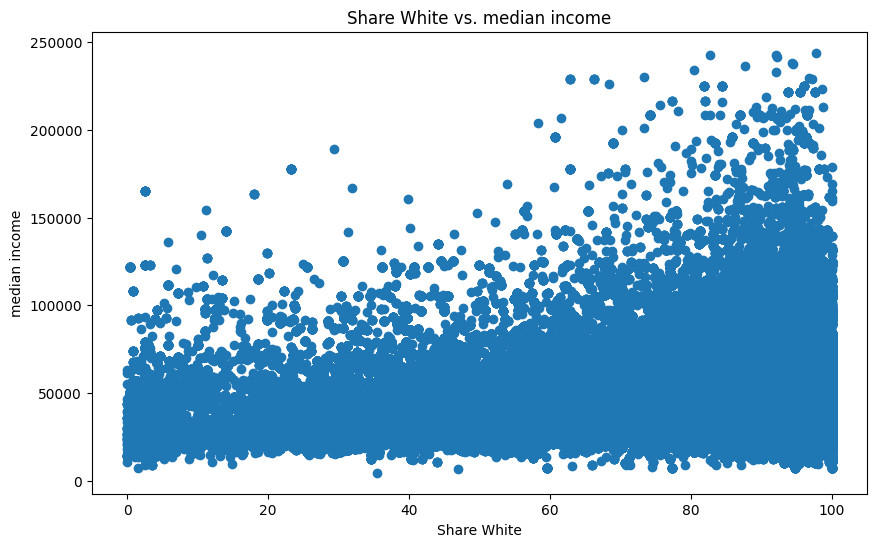

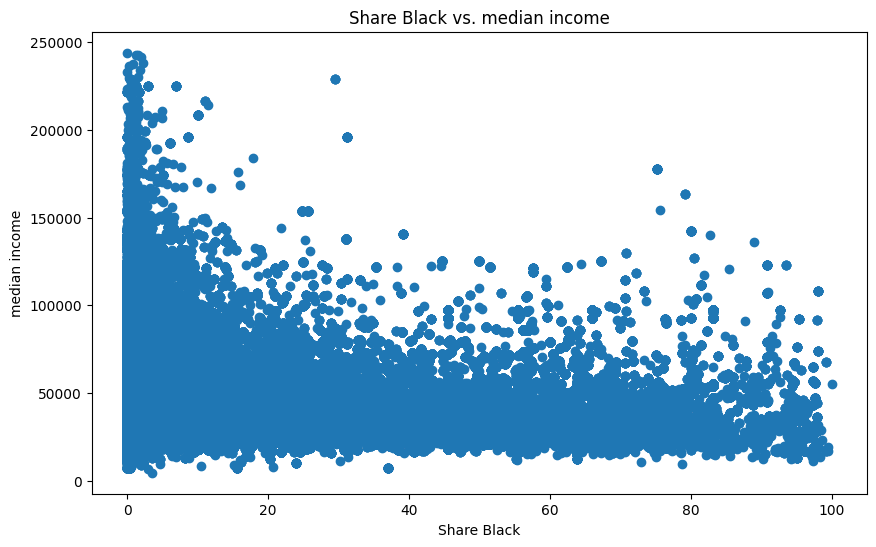

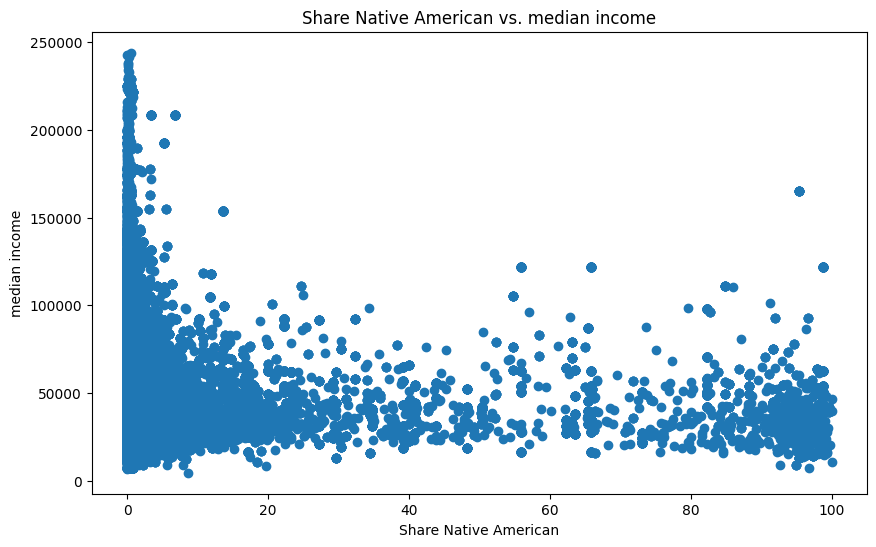

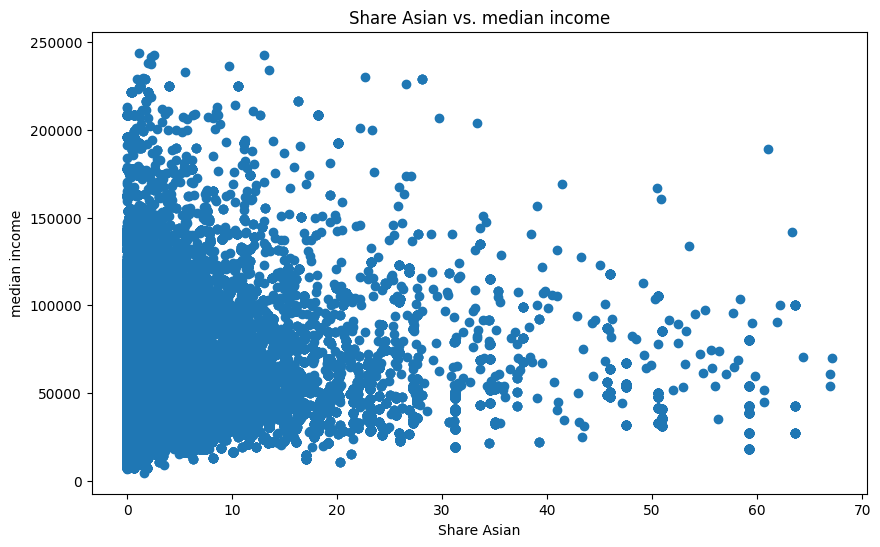

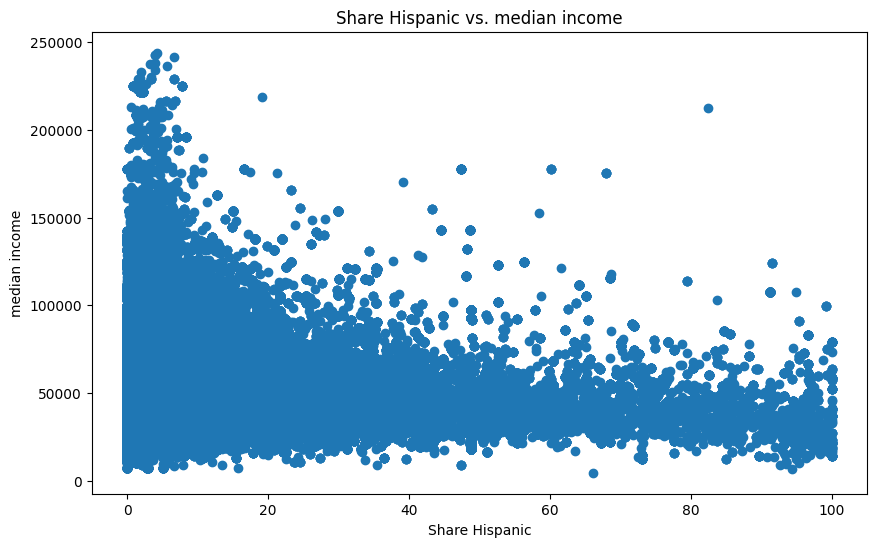

In [ ]:
def create_scatter_plot(df, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    try:
        # Convert to numeric, handling errors
        x_data = pd.to_numeric(df[x_col], errors='coerce')
        y_data = pd.to_numeric(df[y_col], errors='coerce')

        # Drop rows with NaN values after conversion
        valid_indices = ~x_data.isna() & ~y_data.isna()
        x_data = x_data[valid_indices]
        y_data = y_data[valid_indices]

        plt.scatter(x_data, y_data)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
    except KeyError as e:
        print(f"Error creating plot: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Scatter plots for share of race vs. Median Income
for race in ['share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']:
    try:
        create_scatter_plot(merged_data, race, 'median income', f'{race.replace("_", " ").title()} vs. median income', race.replace("_", " ").title(), 'median income')
    except KeyError as e:
        print(f"Error creating plot: {e}")

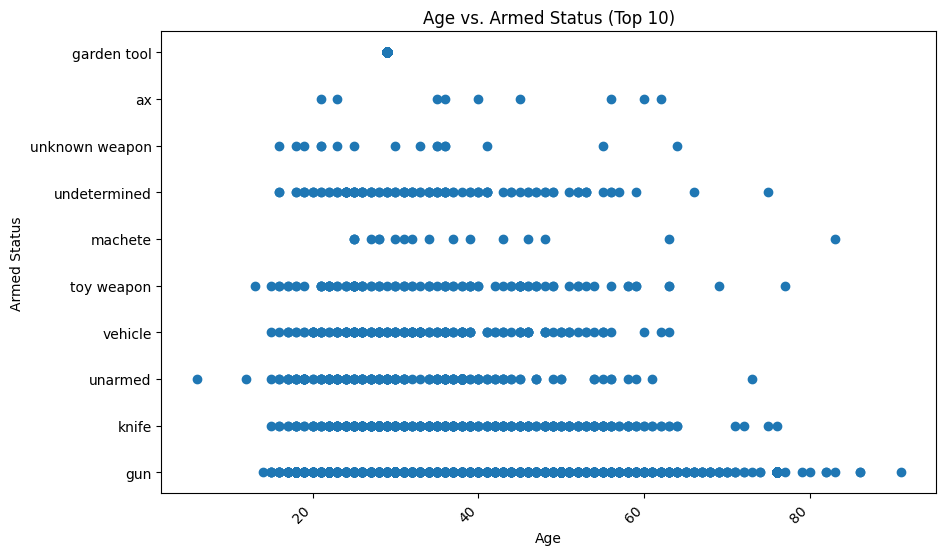

In [ ]:
def create_scatter_plot(df, x_col, y_col, title, xlabel, ylabel):
    try:
        # Find the top 10 most frequent values in y_col
        top_y_values = df[y_col].value_counts().head(10).index

        # Filter the DataFrame to include only rows with y_col in the top 10
        df_filtered = df[df[y_col].isin(top_y_values)]

        # Remove rows with NaN values in x_col or y_col
        df_filtered = df_filtered.dropna(subset=[x_col, y_col])

        # Convert columns to numeric where applicable
        x_data = pd.to_numeric(df_filtered[x_col], errors='coerce')
        y_data = df_filtered[y_col]

        # Create scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(x_data, y_data)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
        plt.show()

    except KeyError as e:
        print(f"Error creating plot: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage with age and armed status
create_scatter_plot(
    merged_data,
    'age',
    'armed',
    'Age vs. Armed Status (Top 10)',
    'Age',
    'Armed Status'
)


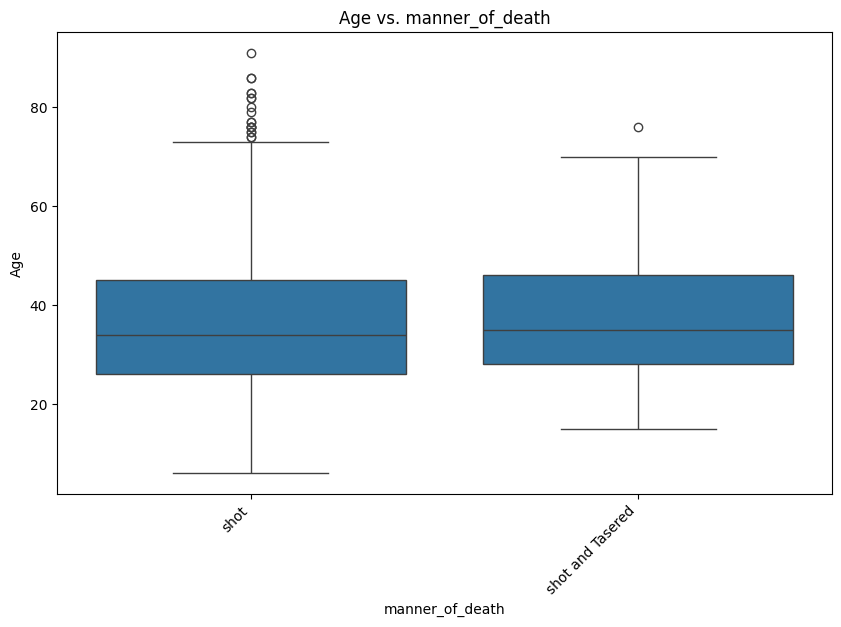

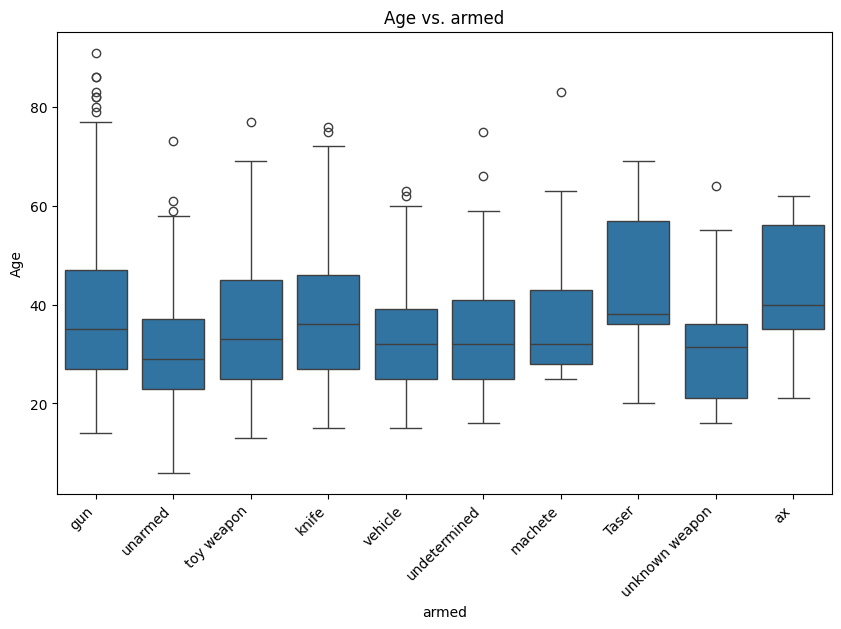

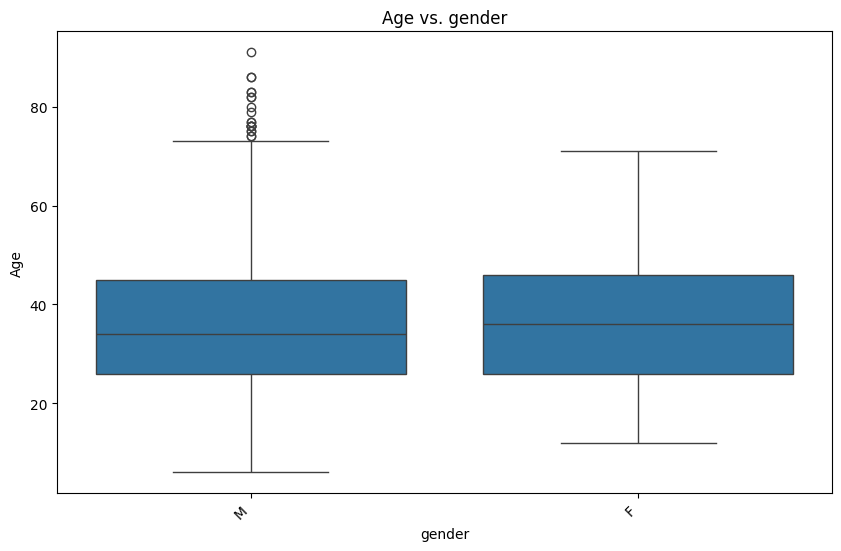

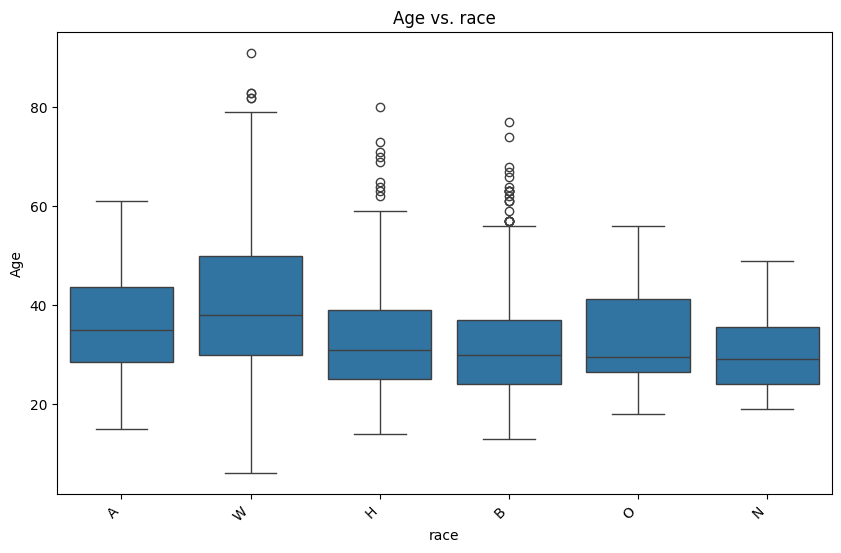

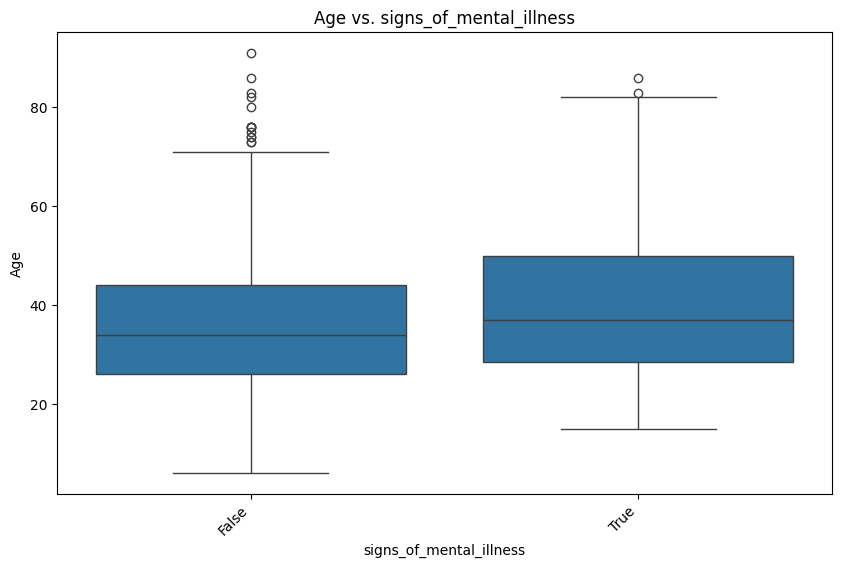

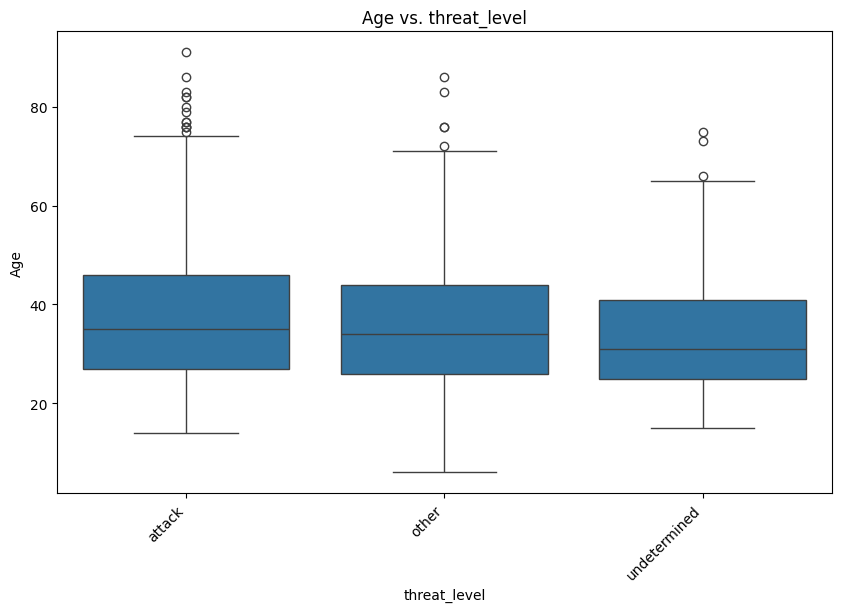

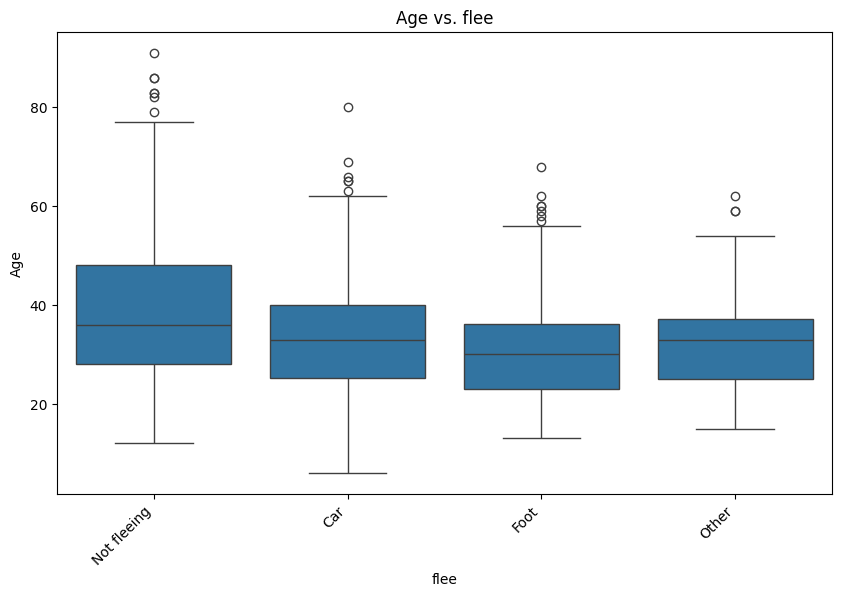

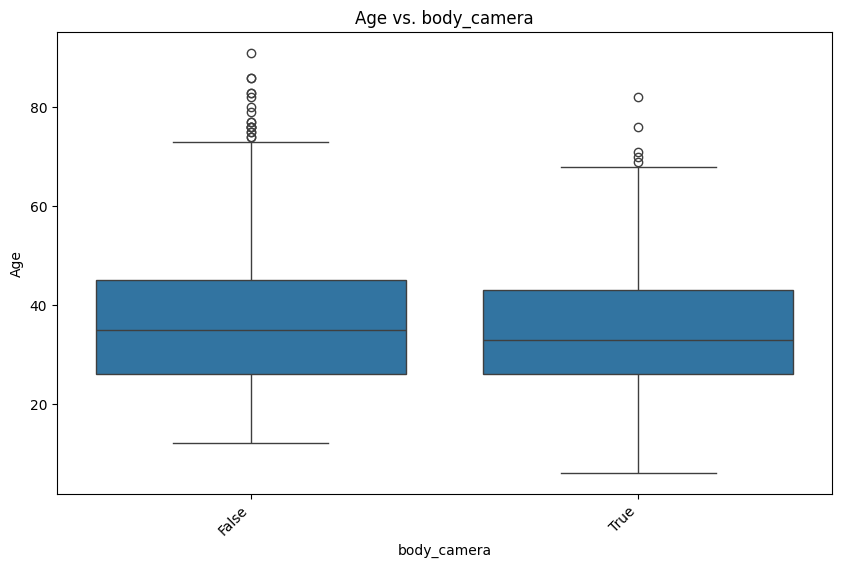

In [ ]:
import seaborn as sns

# Load the dataframe
df = pd.read_csv('Deaths_by_Police_US.csv', encoding='latin-1')

# Convert 'age' to numeric, coercing errors to NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# List of columns to create box plots for
columns_to_plot = ['manner_of_death', 'armed', 'gender', 'race', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera']

# Create box plots
for col in columns_to_plot:
    if col in df.columns:
        # For 'armed', restrict to the top 10 most frequent values
        if col == 'armed':
            top_10_armed = df['armed'].value_counts().head(10).index
            filtered_df = df[df['armed'].isin(top_10_armed)]
        else:
            filtered_df = df  # No filtering for other columns

        # Create boxplot
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=col, y='age', data=filtered_df)
        plt.title(f'Age vs. {col}')
        plt.xlabel(col)
        plt.ylabel('Age')
        plt.xticks(rotation=45, ha='right')
        plt.show()
    else:
        print(f"Column '{col}' not found in the DataFrame.")


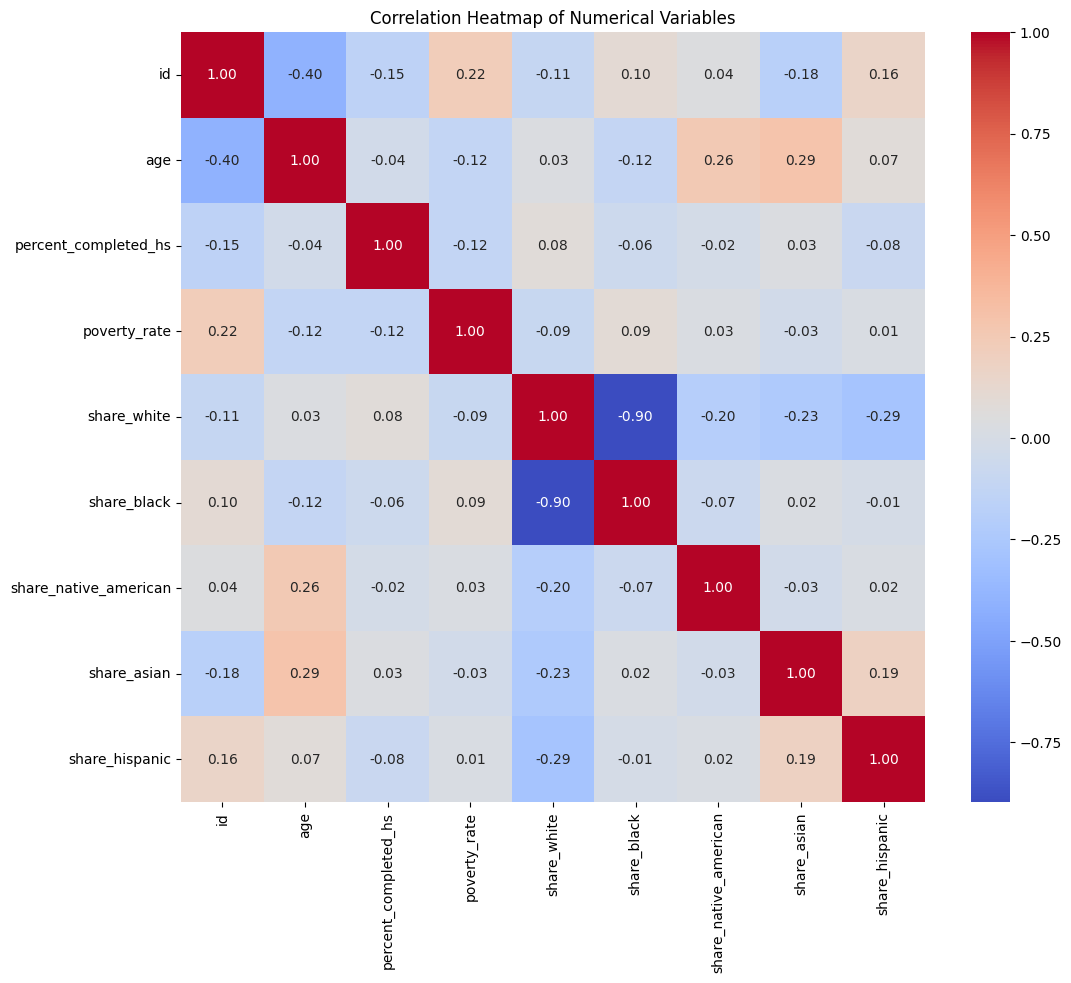

In [ ]:
numerical_cols = merged_data.select_dtypes(include=['number']).columns

correlation_matrix = merged_data[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

***Analyzing Seasonality***

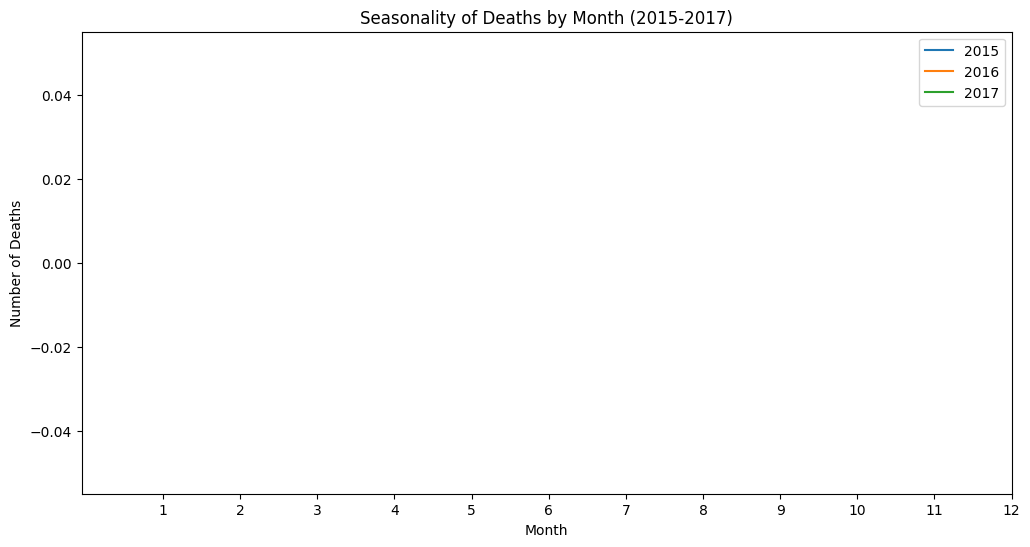

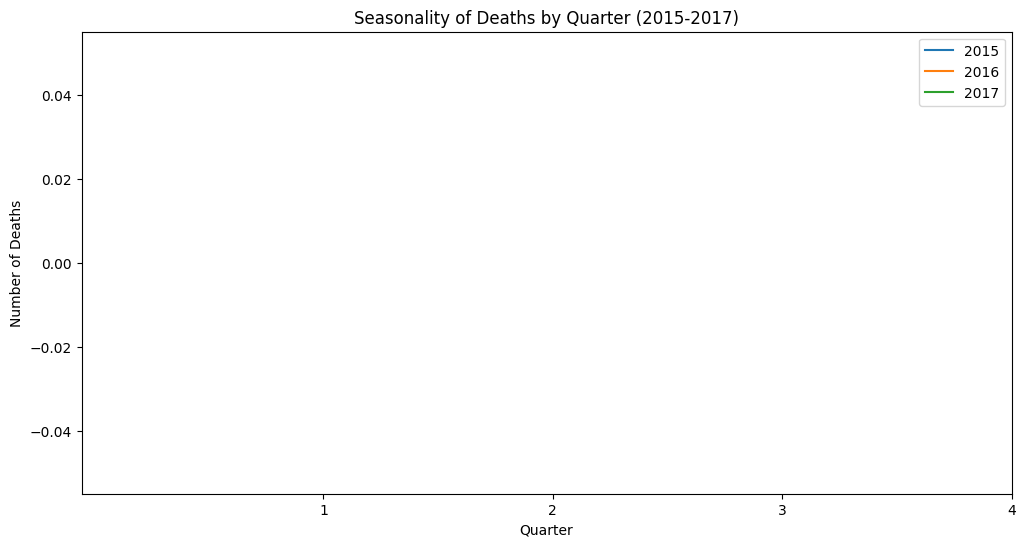

In [ ]:
# Convert the 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Filter data for the years 2015, 2016, and 2017
years_to_analyze = [2015, 2016, 2017]
df_filtered = df[df['year'].isin(years_to_analyze)]

# Group deaths by month for each year and count occurrences
seasonality_by_month = df_filtered.groupby(['year', 'month'])['id'].count().reset_index()

# Group deaths by quarter for each year
seasonality_by_quarter = df_filtered.copy()
seasonality_by_quarter['quarter'] = seasonality_by_quarter['month'].apply(lambda m: (m - 1) // 3 + 1)  # Calculate quarter
seasonality_by_quarter = seasonality_by_quarter.groupby(['year', 'quarter'])['id'].count().reset_index()

# Visualization
plt.figure(figsize=(12, 6))

# Plot seasonality by month
for year in years_to_analyze:
    data_year = seasonality_by_month[seasonality_by_month['year'] == year]
    plt.plot(data_year['month'], data_year['id'], label=str(year))

plt.xlabel("Month")
plt.ylabel("Number of Deaths")
plt.title("Seasonality of Deaths by Month (2015-2017)")
plt.legend()
plt.xticks(range(1, 13))
plt.show()

plt.figure(figsize=(12, 6))

# Plot seasonality by quarter
for year in years_to_analyze:
    data_year = seasonality_by_quarter[seasonality_by_quarter['year'] == year]
    plt.plot(data_year['quarter'], data_year['id'], label=str(year))

plt.xlabel("Quarter")
plt.ylabel("Number of Deaths")
plt.title("Seasonality of Deaths by Quarter (2015-2017)")
plt.legend()
plt.xticks(range(1, 5))  # Set x-axis ticks to display quarter numbers
plt.show()

***Phase 3: Hypothesis Testing***

***Socioeconomic Factors***

*Median Income*

1. Are police-related deaths higher in areas with lower median household income?

  **H₀:** *There is no significant difference in the number of police-related deaths between areas with high and low median household income.*

  **H₁:** *Police-related deaths are higher in areas with lower median household income. *

In [ ]:
city_death_counts = merged_data.groupby('city')['id'].count()
city_death_counts

,id
city,
Aaronsburg Cdp (Centre County),0
Aaronsburg Cdp (Washington County),0
Abanda Cdp,0
Abbeville,1
Abbeville City,0
...,...
Zumbrota City,0
Zuni Pueblo Cdp,0
Zurich City,0


In [ ]:
# Group by city and count deaths
city_death_counts = merged_data.groupby('city')['id'].count().reset_index()

# Merge with median income data (assuming 'median income' exists in merged_data)
city_data = pd.merge(city_death_counts, merged_data[['city', 'median income']], on='city', how='left')

# Remove duplicate city rows after merge
city_data.drop_duplicates(subset=['city'], keep='first', inplace=True)


# Sort by median income in ascending order
city_data_sorted = city_data.sort_values(by='median income', ascending=True)

# Create a new DataFrame with the sorted data
sorted_city_deaths_df = pd.DataFrame(city_data_sorted)

In [ ]:
sorted_city_deaths_df.head()

,city,id,median income
170052,Cliff Cdp,0,(X)
653106,Mcbaine Town,0,(X)
509320,Lake Mary Ronan Cdp,0,(X)
509325,Lake Meredith Estates Cdp,0,(X)
755522,Pioche Cdp,0,(X)


In [ ]:
sorted_city_deaths_df = sorted_city_deaths_df.rename(columns={'id': 'number of deaths'})

In [ ]:
# Find the city with the maximum number of deaths
max_deaths_city = sorted_city_deaths_df.loc[sorted_city_deaths_df['number of deaths'].idxmax()]

# Extract the city name and median income
city_name = max_deaths_city['city']
median_income = max_deaths_city['median income']

print(f"The city with the maximum number of deaths is: {city_name}")
print(f"Its median income is: {median_income}")

The city with the maximum number of deaths is: Lancaster City
Its median income is: 47225


In [ ]:
import statsmodels.api as sm

# Prepare the data for linear regression
# Ensure 'median income' is numeric
sorted_city_deaths_df['median income'] = pd.to_numeric(sorted_city_deaths_df['median income'], errors='coerce')

# Drop rows with NaN values in 'median income' after conversion
sorted_city_deaths_df = sorted_city_deaths_df.dropna(subset=['median income'])

X = sorted_city_deaths_df['median income']
y = sorted_city_deaths_df['number of deaths']

# Add a constant to the independent variable (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

# Extract the coefficients and p-value
intercept = model.params[0]
slope = model.params[1]
p_value = model.pvalues[1]  # p-value for the slope coefficient

print(f"\nIntercept: {intercept}")
print(f"Slope: {slope}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("\nThere is a statistically significant relationship between median income and the number of police-related deaths.")
    if slope < 0:
        print("Police-related deaths tend to be higher in areas with lower median household income.")
    else:
        print("Police-related deaths tend to be higher in areas with higher median household income.")
else:
    print("\nThere is no statistically significant relationship between median income and the number of police-related deaths.")

                            OLS Regression Results                            
Dep. Variable:       number of deaths   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.05882
Date:                Thu, 02 Jan 2025   Prob (F-statistic):              0.808
Time:                        18:24:54   Log-Likelihood:            -1.2678e+05
No. Observations:               22519   AIC:                         2.536e+05
Df Residuals:                   22517   BIC:                         2.536e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7951      1.012      0.786

<ipython-input-28-2a04ea5acd73>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]
<ipython-input-28-2a04ea5acd73>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
<ipython-input-28-2a04ea5acd73>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]  # p-value for the slope coefficient


2. Do areas with lower median income report a higher proportion of unarmed deaths?

  **H₀:** *The proportion of unarmed deaths does not differ between areas with high and low median household income.*
  
  **H₁:** *Areas with lower median income report a higher proportion of unarmed deaths.*

In [ ]:
# Calculate the proportion of unarmed deaths per city
city_unarmed_counts = merged_data[merged_data['armed'] == 'unarmed'].groupby('city')['id'].count().reset_index(name='unarmed_deaths')
city_total_deaths = merged_data.groupby('city')['id'].count().reset_index(name='total_deaths')
city_unarmed_proportions = pd.merge(city_unarmed_counts, city_total_deaths, on='city')
city_unarmed_proportions['unarmed_proportion'] = city_unarmed_proportions['unarmed_deaths'] / city_unarmed_proportions['total_deaths']

# Merge with median income data
city_data_unarmed = pd.merge(city_unarmed_proportions, merged_data[['city', 'median income']], on='city', how='left')
city_data_unarmed.drop_duplicates(subset=['city'], keep='first', inplace=True)

# Prepare data for regression, handling potential errors
city_data_unarmed['median income'] = pd.to_numeric(city_data_unarmed['median income'], errors='coerce')
city_data_unarmed = city_data_unarmed.dropna(subset=['median income', 'unarmed_proportion'])

X = city_data_unarmed['median income']
y = city_data_unarmed['unarmed_proportion']
X = sm.add_constant(X)

# Fit the linear regression model
model_unarmed = sm.OLS(y, X).fit()

# Print the model summary
print(model_unarmed.summary())

# Extract and print coefficients and p-value
intercept_unarmed = model_unarmed.params[0]
slope_unarmed = model_unarmed.params[1]
p_value_unarmed = model_unarmed.pvalues[1]

print(f"\nIntercept (Unarmed): {intercept_unarmed}")
print(f"Slope (Unarmed): {slope_unarmed}")
print(f"P-value (Unarmed): {p_value_unarmed}")

# Interpret the results
if p_value_unarmed < 0.05:
    print("\nThere is a statistically significant relationship between median income and the proportion of unarmed deaths.")
    if slope_unarmed < 0:
        print("Areas with lower median income tend to have a higher proportion of unarmed deaths.")
    else:
        print("Areas with higher median income tend to have a higher proportion of unarmed deaths.")
else:
    print("\nThere is no statistically significant relationship between median income and the proportion of unarmed deaths.")

                            OLS Regression Results                            
Dep. Variable:     unarmed_proportion   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                 -0.136
Method:                 Least Squares   F-statistic:                    0.7599
Date:                Thu, 02 Jan 2025   Prob (F-statistic):              0.544
Time:                        18:24:55   Log-Likelihood:               -0.44039
No. Observations:                   3   AIC:                             4.881
Df Residuals:                       1   BIC:                             3.078
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2297      0.850      1.447

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
<ipython-input-29-76ca9bc74007>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_unarmed = model_unarmed.params[0]
<ipython-input-29-76ca9bc74007>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope_unarmed = model_unarmed.params[1]
<ipython-input-29-76ca9bc74007>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, int

*Poverty Rate*

1. Is the proportion of deaths involving minorities higher in areas with a higher poverty rate?

  **H₀:** *The proportion of deaths involving minorities is not significantly associated with the poverty rate.*
  
  **H₁:** *The proportion of deaths involving minorities is higher in areas with a higher poverty rate.*

In [ ]:
# Calculate the proportion of minority deaths per city
minority_races = ['Black', 'Hispanic', 'Asian', 'Native American']  # Define minority races
merged_data['minority_death'] = merged_data['race'].apply(lambda x: 1 if x in minority_races else 0)
city_minority_counts = merged_data.groupby('city')['minority_death'].sum().reset_index(name='minority_deaths')
city_total_deaths = merged_data.groupby('city')['id'].count().reset_index(name='total_deaths')
city_minority_proportions = pd.merge(city_minority_counts, city_total_deaths, on='city')
city_minority_proportions['minority_proportion'] = city_minority_proportions['minority_deaths'] / city_minority_proportions['total_deaths']

# Merge with poverty rate data
city_data_minority = pd.merge(city_minority_proportions, merged_data[['city', 'poverty_rate']], on='city', how='left')
city_data_minority.drop_duplicates(subset=['city'], keep='first', inplace=True)

# Prepare data for regression, handling potential errors
city_data_minority['poverty_rate'] = pd.to_numeric(city_data_minority['poverty_rate'], errors='coerce')
city_data_minority = city_data_minority.dropna(subset=['poverty_rate', 'minority_proportion'])

X = city_data_minority['poverty_rate']
y = city_data_minority['minority_proportion']
X = sm.add_constant(X)

# Fit the linear regression model
model_minority = sm.OLS(y, X).fit()

# Print the model summary
print(model_minority.summary())

# Extract and print coefficients and p-value
intercept_minority = model_minority.params[0]
slope_minority = model_minority.params[1]
p_value_minority = model_minority.pvalues[1]

print(f"\nIntercept (Minority): {intercept_minority}")
print(f"Slope (Minority): {slope_minority}")
print(f"P-value (Minority): {p_value_minority}")

# Interpret the results
if p_value_minority < 0.05:
    print("\nThere is a statistically significant relationship between poverty rate and the proportion of minority deaths.")
    if slope_minority > 0:
        print("Areas with higher poverty rates tend to have a higher proportion of minority deaths.")
    else:
        print("Areas with higher poverty rates tend to have a lower proportion of minority deaths.")
else:
    print("\nThere is no statistically significant relationship between poverty rate and the proportion of minority deaths.")

                             OLS Regression Results                            
Dep. Variable:     minority_proportion   R-squared:                         nan
Model:                             OLS   Adj. R-squared:                    nan
Method:                  Least Squares   F-statistic:                       nan
Date:                 Thu, 02 Jan 2025   Prob (F-statistic):                nan
Time:                         18:24:56   Log-Likelihood:                    inf
No. Observations:                   19   AIC:                              -inf
Df Residuals:                       17   BIC:                              -inf
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const                 0          0    

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
<ipython-input-30-4732eed07a4a>:


2. Are police-related deaths involving individuals showing signs of mental illness more common in areas with higher poverty?

  **H₀:** *Police-related deaths involving individuals showing signs of mental illness are not associated with the poverty rate.*
  
  **H₁:** *Police-related deaths involving individuals showing signs of mental illness are more common in areas with higher poverty.*

In [ ]:
# Convert 'signs_of_mental_illness' to numeric (0 or 1) if it's not already
merged_data['signs_of_mental_illness'] = pd.to_numeric(merged_data['signs_of_mental_illness'], errors='coerce').fillna(0).astype(int)

# Fit the model
model = smf.ols('signs_of_mental_illness ~ poverty_rate', data=merged_data).fit()

# Print the model summary
print(model.summary())

# Access the p-value for the poverty_rate coefficient
p_value = model.pvalues['poverty_rate']

# Interpret the results
alpha = 0.05  # significance level

if p_value < alpha:
    print(f"\nThere is a statistically significant association between poverty rate and police-related deaths involving mental illness (p-value = {p_value:.3f}).")
else:
    print(f"\nThere is no statistically significant association between poverty rate and police-related deaths involving mental illness (p-value = {p_value:.3f}).")

                               OLS Regression Results                              
Dep. Variable:     signs_of_mental_illness   R-squared:                       0.051
Model:                                 OLS   Adj. R-squared:                  0.051
Method:                      Least Squares   F-statistic:                     700.1
Date:                     Thu, 02 Jan 2025   Prob (F-statistic):          2.75e-150
Time:                             19:09:36   Log-Likelihood:                -2883.4
No. Observations:                    12937   AIC:                             5771.
Df Residuals:                        12935   BIC:                             5786.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

*Education Level*

1. Are deaths involving body cameras less common in areas with higher educational attainment?

  **H₀:** *The frequency of deaths involving body cameras is not associated with educational attainment.*
  
  **H₁:** *Deaths involving body cameras are less common in areas with higher educational attainment.*

In [ ]:
# Convert 'body_camera' and 'high_school_or_higher' to numeric
merged_data['body_camera'] = pd.to_numeric(merged_data['body_camera'], errors='coerce').fillna(0).astype(int)
merged_data['percent_completed_hs'] = pd.to_numeric(merged_data['percent_completed_hs'], errors='coerce')

# Drop rows with missing values in relevant columns
merged_data = merged_data.dropna(subset=['body_camera', 'percent_completed_hs'])


# Fit the linear regression model
model = smf.ols('body_camera ~ percent_completed_hs', data=merged_data).fit()

# Print the model summary
print(model.summary())

# Access the p-value for the high_school_or_higher coefficient
p_value = model.pvalues['percent_completed_hs']

# Interpret the results
alpha = 0.05  # significance level

if p_value < alpha:
    print(f"\nThere is a statistically significant association between educational attainment and deaths involving body cameras (p-value = {p_value:.3f}).")
else:
    print(f"\nThere is no statistically significant association between educational attainment and deaths involving body cameras (p-value = {p_value:.3f}).")

                            OLS Regression Results                            
Dep. Variable:            body_camera   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     195.3
Date:                Thu, 02 Jan 2025   Prob (F-statistic):           2.28e-44
Time:                        18:24:57   Log-Likelihood:             1.7988e+06
No. Observations:              968077   AIC:                        -3.598e+06
Df Residuals:                  968075   BIC:                        -3.598e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0039 

***Demographics***

*Race and Population Share*

1. Do police-related deaths disproportionately affect racial groups based on their population share (e.g., share_black vs. share_white)?

  **H₀:** *Police-related deaths do not disproportionately affect racial groups based on their population share.*
  
  **H₁** *Police-related deaths disproportionately affect racial groups based on their population share.*

In [ ]:
if 'total_deaths' not in merged_data:
  merged_data['total_deaths'] = merged_data.groupby('city')['id'].transform('count')

# Fit the Multiple Linear Regression model
model = smf.ols('total_deaths ~ share_black + share_white', data=merged_data).fit()
print(model.summary())

# Extract p-values for the coefficients
p_value_black = model.pvalues['share_black']
p_value_white = model.pvalues['share_white']


# Interpret the results
alpha = 0.05  # Significance level

print("\nHypothesis Testing Results:")

if p_value_black < alpha:
    print(f"  There is a statistically significant association between the share of Black population and total deaths (p-value = {p_value_black:.3f}).")
else:
    print(f"  There is no statistically significant association between the share of Black population and total deaths (p-value = {p_value_black:.3f}).")

if p_value_white < alpha:
    print(f"  There is a statistically significant association between the share of White population and total deaths (p-value = {p_value_white:.3f}).")
else:
    print(f"  There is no statistically significant association between the share of White population and total deaths (p-value = {p_value_white:.3f}).")

                            OLS Regression Results                            
Dep. Variable:           total_deaths   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     711.4
Date:                Thu, 02 Jan 2025   Prob (F-statistic):          1.87e-309
Time:                        18:43:25   Log-Likelihood:            -8.0702e+06
No. Observations:              967867   AIC:                         1.614e+07
Df Residuals:                  967864   BIC:                         1.614e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     278.2232     10.741     25.903      

*Gender*

1. Is there a significant difference in the average age of male and female victims in police-related deaths?

  **H₀:** *The average age of male and female victims in police-related deaths is the same.*
  
  **H₁:** *There is a significant difference in the average age of male and female victims in police-related deaths.*

In [ ]:
# Ensure 'gender' exists, is valid, and drop missing values
if 'gender' in merged_data.columns:
    merged_data['gender'] = merged_data['gender'].str.strip().str.lower()  # Standardize gender values
    merged_data = merged_data.dropna(subset=['age', 'gender'])  # Drop rows with missing age or gender

    # Fit the linear regression model
    model = smf.ols('age ~ gender', data=merged_data).fit()

    # Print the model summary to inspect variable names
    print(model.summary())

    # Access the p-value for the gender dummy variable (adjust for your data)
    # Dynamically extract the name of the dummy variable
    dummy_var_name = [var for var in model.params.index if 'gender' in var][0]
    p_value = model.pvalues[dummy_var_name]

    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        print(f"\nThere is a statistically significant difference in the average age of male and female victims (p-value = {p_value:.3f}).")
    else:
        print(f"\nThere is no statistically significant difference in the average age of male and female victims (p-value = {p_value:.3f}).")
else:
    print("'gender' column not found in the dataset.")


                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.792
Date:                Thu, 02 Jan 2025   Prob (F-statistic):              0.181
Time:                        19:09:19   Log-Likelihood:                -47956.
No. Observations:               12937   AIC:                         9.592e+04
Df Residuals:                   12935   BIC:                         9.593e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      31.0000      6.969      4.448      

2. Are females less likely than males to be armed during police-related deaths?

  **H₀:** *The likelihood of being armed during police-related deaths does not differ between males and females.*
  
  **H₁:** *Females are less likely than males to be armed during police-related deaths.*

In [ ]:
# Ensure 'armed' and 'gender' columns exist and handle missing values
if {'armed', 'gender'}.issubset(merged_data.columns):
    merged_data['armed'] = merged_data['armed'].astype(str)
    merged_data['gender'] = merged_data['gender'].str.strip().str.lower()
    merged_data = merged_data.dropna(subset=['armed', 'gender'])

    # Convert 'armed' to a binary variable (1 if armed, 0 otherwise)
    merged_data['is_armed'] = merged_data['armed'].apply(lambda x: 1 if x.lower() != 'unarmed' else 0)

    # Add a small random noise to the 'gender' variable to address potential singularity
    # This can help if there's perfect separation or near-perfect collinearity
    merged_data['gender_jittered'] = merged_data['gender'].astype('category').cat.codes + np.random.normal(0, 0.01, len(merged_data))

    # Fit the logistic regression model using the jittered gender variable
    model = smf.logit('is_armed ~ gender_jittered', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-value for the gender coefficient (using the jittered variable)
    p_value = model.pvalues['gender_jittered']

    # Odds ratio and confidence interval for gender (using the jittered variable)
    odds_ratio = np.exp(model.params['gender_jittered'])
    conf_int = np.exp(model.conf_int().loc['gender_jittered'])

    print(f"\nOdds Ratio for Gender: {odds_ratio:.3f} ({conf_int[0]:.3f}, {conf_int[1]:.3f})")

    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        if odds_ratio < 1:
            print(f"\nFemales are less likely to be armed during police-related deaths (p-value = {p_value:.3f}).")
        else:
            print(f"\nFemales are more likely to be armed during police-related deaths (p-value = {p_value:.3f}).")
    else:
        print(f"\nThere is no statistically significant difference in the likelihood of being armed between males and females (p-value = {p_value:.3f}).")
else:
    print("'armed' or 'gender' column not found in the dataset.")

Optimization terminated successfully.
         Current function value: 0.038781
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               is_armed   No. Observations:                12937
Model:                          Logit   Df Residuals:                    12935
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:               0.0001894
Time:                        19:14:30   Log-Likelihood:                -501.71
converged:                       True   LL-Null:                       -501.80
Covariance Type:            nonrobust   LLR p-value:                    0.6628
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.5213     10.904      0.873      0.383     -11.851      30.893
gender_jitter

*Age*

1. Are younger individuals (<30 years) more likely to flee during encounters leading to police-related deaths?

  **H₀:** *Younger individuals (<30 years) are not more likely to flee during encounters leading to police-related deaths.*
  
  **H₁:** *Younger individuals (<30 years) are more likely to flee during encounters leading to police-related deaths.*

In [ ]:
# Ensure 'flee' and 'age' columns exist and handle missing values
if {'flee', 'age'}.issubset(merged_data.columns):
    merged_data = merged_data.dropna(subset=['flee', 'age'])

    # Create a binary variable for age < 30
    merged_data['younger_than_30'] = (merged_data['age'] < 30).astype(int)

    # Convert 'flee' to numerical if it's categorical:
    if merged_data['flee'].dtype == object:  # Check if 'flee' is of object type
        # Assuming 'Not fleeing' is one category, and the rest indicate fleeing
        merged_data['flee_numerical'] = merged_data['flee'].apply(lambda x: 0 if x == 'Not fleeing' else 1)
    else:
        merged_data['flee_numerical'] = merged_data['flee']  # If already numerical, keep as is

    # Fit the logistic regression model using the numerical 'flee' column
    model = smf.logit('flee_numerical ~ younger_than_30', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-value for the younger_than_30 coefficient
    p_value = model.pvalues['younger_than_30']

     # Odds ratio and confidence interval for age
    odds_ratio = np.exp(model.params['younger_than_30'])
    conf_int = np.exp(model.conf_int().loc['younger_than_30'])

    print(f"\nOdds Ratio for Age < 30: {odds_ratio:.3f} ({conf_int[0]:.3f}, {conf_int[1]:.3f})")


    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        if odds_ratio > 1:
            print(f"\nYounger individuals (<30 years) are more likely to flee during encounters (p-value = {p_value:.3f}).")
        else:
            print(f"\nYounger individuals (<30 years) are less likely to flee during encounters (p-value = {p_value:.3f}).")
    else:
        print(f"\nThere is no statistically significant association between age (<30) and fleeing during encounters (p-value = {p_value:.3f}).")
else:
    print("'flee' or 'age' column not found in the dataset.")

Optimization terminated successfully.
         Current function value: 0.014657
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:         flee_numerical   No. Observations:                12937
Model:                          Logit   Df Residuals:                    12935
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                  0.3290
Time:                        19:17:54   Log-Likelihood:                -189.62
converged:                       True   LL-Null:                       -282.60
Covariance Type:            nonrobust   LLR p-value:                 2.423e-42
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.1254      0.164    -19.103      0.000      -3.446      -2.805
younger_than_

2. Is the average age of victims higher in incidents involving body cameras?

  **H₀:** *The average age of victims does not differ between incidents involving and not involving body cameras.*
  
  **H₁:** *The average age of victims is higher in incidents involving body cameras.*

In [ ]:
# Ensure 'body_camera' and 'age' columns exist and handle missing values
if {'body_camera', 'age'}.issubset(merged_data.columns):
    merged_data = merged_data.dropna(subset=['body_camera', 'age'])

    # Convert 'body_camera' to numeric if it's not already
    merged_data['body_camera'] = pd.to_numeric(merged_data['body_camera'], errors='coerce').fillna(0).astype(int)

    # Fit the linear regression model
    model = smf.ols('age ~ body_camera', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-value for the body_camera coefficient
    p_value = model.pvalues['body_camera']

    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        print(f"\nThere is a statistically significant association between body camera presence and victim age (p-value = {p_value:.3f}).")
        if model.params['body_camera'] > 0:
          print("The average age of victims is higher in incidents involving body cameras.")
        else:
          print("The average age of victims is lower in incidents involving body cameras.")
    else:
        print(f"\nThere is no statistically significant association between body camera presence and victim age (p-value = {p_value:.3f}).")
else:
    print("'body_camera' or 'age' column not found in the dataset.")

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     909.9
Date:                Thu, 02 Jan 2025   Prob (F-statistic):          3.17e-193
Time:                        19:20:31   Log-Likelihood:                -47517.
No. Observations:               12937   AIC:                         9.504e+04
Df Residuals:                   12935   BIC:                         9.505e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      20.7977      0.089    234.673      

***Threat and Circumstance***

*Signs of Mental Illness*

1. Are deaths involving individuals with signs of mental illness more likely to occur in areas with lower educational attainment?

  **H₀:** *Deaths involving individuals with signs of mental illness are not associated with educational attainment.*
  
  **H₁:** *Deaths involving individuals with signs of mental illness are more likely to occur in areas with lower educational attainment.*

In [ ]:
# Ensure necessary columns exist and handle missing values
if {'signs_of_mental_illness', 'percent_completed_hs'}.issubset(merged_data.columns):
    merged_data = merged_data.dropna(subset=['signs_of_mental_illness', 'percent_completed_hs'])

    # Convert 'signs_of_mental_illness' to numeric (0 or 1) if it's not already
    merged_data['signs_of_mental_illness'] = pd.to_numeric(merged_data['signs_of_mental_illness'], errors='coerce').fillna(0).astype(int)

    # Fit the logistic regression model
    model = smf.logit('signs_of_mental_illness ~ percent_completed_hs', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-value for the percent_completed_hs coefficient
    p_value = model.pvalues['percent_completed_hs']

    # Odds ratio and confidence interval
    odds_ratio = np.exp(model.params['percent_completed_hs'])
    conf_int = np.exp(model.conf_int().loc['percent_completed_hs'])

    print(f"\nOdds Ratio for % High School Completion: {odds_ratio:.3f} ({conf_int[0]:.3f}, {conf_int[1]:.3f})")

    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        if odds_ratio < 1:
            print(f"\nDeaths involving mental illness are more likely in areas with lower educational attainment (p-value = {p_value:.3f}).")
        else:
            print(f"\nDeaths involving mental illness are more likely in areas with higher educational attainment (p-value = {p_value:.3f}).")
    else:
        print(f"\nThere is no statistically significant association between mental illness deaths and educational attainment (p-value = {p_value:.3f}).")
else:
    print("'signs_of_mental_illness' or 'percent_completed_hs' column not found in the dataset.")

Optimization terminated successfully.
         Current function value: 0.327165
         Iterations 7
                              Logit Regression Results                             
Dep. Variable:     signs_of_mental_illness   No. Observations:                12937
Model:                               Logit   Df Residuals:                    12935
Method:                                MLE   Df Model:                            1
Date:                     Thu, 02 Jan 2025   Pseudo R-squ.:                 0.04462
Time:                             19:24:32   Log-Likelihood:                -4232.5
converged:                            True   LL-Null:                       -4430.2
Covariance Type:                 nonrobust   LLR p-value:                 5.721e-88
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -9.3913      0.406    -2

2. Is the threat level (attack vs. other) significantly associated with mental illness?

  **H₀:** *Threat level (attack vs. other) is not associated with signs of mental illness.*
  
  **H₁:** *Threat level (attack vs. other) is significantly associated with signs of mental illness.*

In [ ]:
# Ensure necessary columns exist and handle missing values
if {'threat_level', 'signs_of_mental_illness'}.issubset(merged_data.columns):
    merged_data = merged_data.dropna(subset=['threat_level', 'signs_of_mental_illness'])

    # Convert 'signs_of_mental_illness' to numeric (0 or 1) if it's not already
    merged_data['signs_of_mental_illness'] = pd.to_numeric(merged_data['signs_of_mental_illness'], errors='coerce').fillna(0).astype(int)

    # Fit the logistic regression model
    model = smf.logit('signs_of_mental_illness ~ C(threat_level)', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-values for the threat_level coefficients
    p_values = model.pvalues[1:] # Exclude the intercept

    # Print the p-values
    print("\nP-values for threat levels (excluding intercept):")
    for level, p_value in p_values.items():
        print(f"{level}: {p_value}")

    # Interpret the results (example for one level - adapt as needed)
    alpha = 0.05
    if p_values.iloc[0] < alpha:
      print("\nThere is a statistically significant association between threat level and signs of mental illness.")
    else:
      print("\nThere is no statistically significant association between threat level and signs of mental illness.")

else:
    print("'threat_level' or 'signs_of_mental_illness' column not found in the dataset.")

         Current function value: 0.179160
         Iterations: 35
                              Logit Regression Results                             
Dep. Variable:     signs_of_mental_illness   No. Observations:                12937
Model:                               Logit   Df Residuals:                    12934
Method:                                MLE   Df Model:                            2
Date:                     Thu, 02 Jan 2025   Pseudo R-squ.:                  0.4768
Time:                             19:26:19   Log-Likelihood:                -2317.8
converged:                           False   LL-Null:                       -4430.2
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -4.6447      0.101    -45.9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


*Threat Level*

1. Is the threat level (attack vs. other) significantly different across armed and unarmed individuals?

  **H₀:** *Threat level (attack vs. other) is not significantly different between armed and unarmed individuals.*
  
  **H₁:** *Threat level (attack vs. other) is significantly different between armed and unarmed individuals.*


In [ ]:
# Ensure necessary columns exist and handle missing values
if {'threat_level', 'armed'}.issubset(merged_data.columns):
    merged_data = merged_data.dropna(subset=['threat_level', 'armed'])

    # Convert 'armed' to a binary variable (1 if armed, 0 otherwise)
    merged_data['is_armed'] = merged_data['armed'].apply(lambda x: 1 if x.lower() != 'unarmed' else 0)

    # Fit the logistic regression model
    model = smf.logit('is_armed ~ C(threat_level)', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-values for the threat_level coefficients
    p_values = model.pvalues[1:]  # Exclude intercept

    # Print the p-values for each threat level
    print("\nP-values for threat levels (excluding intercept):")
    for level, p_value in p_values.items():
        print(f"{level}: {p_value}")

    # Interpret results (example - adapt as needed)
    alpha = 0.05
    if any(p_value < alpha for p_value in p_values):
        print("\nThere is a statistically significant difference in threat level between armed and unarmed individuals.")
    else:
        print("\nThere is no statistically significant difference in threat level between armed and unarmed individuals.")

else:
    print("'threat_level' or 'armed' column not found in the dataset.")

         Current function value: 0.037893
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:               is_armed   No. Observations:                12937
Model:                          Logit   Df Residuals:                    12934
Method:                           MLE   Df Model:                            2
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                 0.02307
Time:                        19:28:58   Log-Likelihood:                -490.22
converged:                      False   LL-Null:                       -501.80
Covariance Type:            nonrobust   LLR p-value:                 9.376e-06
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           4.8471      0.112     43.454      0.000       4.628       5.066
C(threat_level)[T.other]            2.2981      0.716      3.209    

2. Are deaths classified as "attack" more likely to involve minorities?

  **H₀:** *Deaths classified as "attack" are not more likely to involve minorities.*
  
  **H₁:** *Deaths classified as "attack" are more likely to involve minorities.*

In [ ]:
# Assuming 'merged_data' is your DataFrame and it contains columns 'threat_level', 'share_black', 'share_hispanic', etc.
# Create a combined minority share variable
if {'share_black', 'share_hispanic', 'share_asian', 'share_native_american'}.issubset(merged_data.columns):
    merged_data['minority_share'] = merged_data['share_black'] + merged_data['share_hispanic'] + merged_data['share_asian'] + merged_data['share_native_american']

    # Handle missing values
    merged_data = merged_data.dropna(subset=['threat_level', 'minority_share'])

    # Convert 'threat_level' to a binary variable (1 if 'attack', 0 otherwise)
    merged_data['is_attack'] = (merged_data['threat_level'] == 'attack').astype(int)

    # Fit the logistic regression model
    model = smf.logit('is_attack ~ minority_share', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-value and odds ratio
    p_value = model.pvalues['minority_share']
    odds_ratio = np.exp(model.params['minority_share'])
    conf_int = np.exp(model.conf_int().loc['minority_share'])

    print(f"\nOdds Ratio for Minority Share: {odds_ratio:.3f} ({conf_int[0]:.3f}, {conf_int[1]:.3f})")

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        if odds_ratio > 1:
            print(f"\nDeaths classified as 'attack' are more likely to involve minorities (p-value = {p_value:.3f}).")
        else:
            print(f"\nDeaths classified as 'attack' are less likely to involve minorities (p-value = {p_value:.3f}).")
    else:
        print(f"\nThere is no statistically significant association between 'attack' deaths and minority share (p-value = {p_value:.3f}).")
else:
    print("Required minority share columns not found in the dataset.")

Optimization terminated successfully.
         Current function value: 0.492739
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              is_attack   No. Observations:                12934
Model:                          Logit   Df Residuals:                    12932
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                0.004604
Time:                        19:30:51   Log-Likelihood:                -6373.1
converged:                       True   LL-Null:                       -6402.6
Covariance Type:            nonrobust   LLR p-value:                 1.614e-14
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.2655      0.029     44.292      0.000       1.210       1.322
minority_share   

*Body Camera*

1. Are police-related deaths with body cameras more likely to involve armed individuals?

  **H₀:** *Police-related deaths with body cameras are not more likely to involve armed individuals.*
  
  **H₁:** *Police-related deaths with body cameras are more likely to involve armed individuals.*

In [ ]:
# Ensure necessary columns exist and handle missing values
if {'body_camera', 'armed'}.issubset(merged_data.columns):
    merged_data = merged_data.dropna(subset=['body_camera', 'armed'])

    # Convert 'armed' to a binary variable (1 if armed, 0 otherwise)
    merged_data['is_armed'] = merged_data['armed'].apply(lambda x: 1 if x.lower() != 'unarmed' else 0)

    # Convert 'body_camera' to numeric if it's not already
    merged_data['body_camera'] = pd.to_numeric(merged_data['body_camera'], errors='coerce').fillna(0).astype(int)

    # Fit the logistic regression model
    model = smf.logit('is_armed ~ body_camera', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-value for the body_camera coefficient
    p_value = model.pvalues['body_camera']

    # Odds ratio and confidence interval for body camera
    odds_ratio = np.exp(model.params['body_camera'])
    conf_int = np.exp(model.conf_int().loc['body_camera'])

    print(f"\nOdds Ratio for Body Camera: {odds_ratio:.3f} ({conf_int[0]:.3f}, {conf_int[1]:.3f})")

    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        if odds_ratio > 1:
            print(f"\nPolice-related deaths with body cameras are more likely to involve armed individuals (p-value = {p_value:.3f}).")
        else:
            print(f"\nPolice-related deaths with body cameras are less likely to involve armed individuals (p-value = {p_value:.3f}).")
    else:
        print(f"\nThere is no statistically significant association between body camera presence and whether the individual was armed (p-value = {p_value:.3f}).")
else:
    print("'body_camera' or 'armed' column not found in the dataset.")

Optimization terminated successfully.
         Current function value: 0.038323
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:               is_armed   No. Observations:                12934
Model:                          Logit   Df Residuals:                    12932
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                 0.01217
Time:                        19:39:48   Log-Likelihood:                -495.67
converged:                       True   LL-Null:                       -501.78
Covariance Type:            nonrobust   LLR p-value:                 0.0004736
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.9409      0.111     44.582      0.000       4.724       5.158
body_camera     2.2890   

2. Do areas with higher educational attainment report more body camera usage in incidents?

  **H₀:** *Body camera usage in incidents is not associated with educational attainment.*
  
  **H₁:** *Areas with higher educational attainment report more body camera usage in incidents.*


In [ ]:
# Ensure necessary columns exist and handle missing values
if {'body_camera', 'percent_completed_hs'}.issubset(merged_data.columns):
    merged_data = merged_data.dropna(subset=['body_camera', 'percent_completed_hs'])

    # Convert 'body_camera' to numeric if it's not already
    merged_data['body_camera'] = pd.to_numeric(merged_data['body_camera'], errors='coerce').fillna(0).astype(int)

    # Fit the linear regression model
    model = smf.ols('body_camera ~ percent_completed_hs', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-value for the percent_completed_hs coefficient
    p_value = model.pvalues['percent_completed_hs']

    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        print(f"\nThere is a statistically significant association between educational attainment and body camera usage (p-value = {p_value:.3f}).")
        if model.params['percent_completed_hs'] > 0:
            print("Areas with higher educational attainment report more body camera usage.")
        else:
            print("Areas with higher educational attainment report less body camera usage.")
    else:
        print(f"\nThere is no statistically significant association between educational attainment and body camera usage (p-value = {p_value:.3f}).")
else:
    print("'body_camera' or 'percent_completed_hs' column not found in the dataset.")

                            OLS Regression Results                            
Dep. Variable:            body_camera   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     316.0
Date:                Thu, 02 Jan 2025   Prob (F-statistic):           7.39e-70
Time:                        19:41:56   Log-Likelihood:                -2999.2
No. Observations:               12934   AIC:                             6002.
Df Residuals:                   12932   BIC:                             6017.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.4191 

***Behaviour and Actions***

*Fleeing Status*


1. Is fleeing behavior more common among younger individuals (<30 years)?

  **H₀:** *Fleeing behavior is not more common among younger individuals (<30 years).*
  
  **H₁:** *Fleeing behavior is more common among younger individuals (<30 years).*

In [ ]:
# Assuming 'merged_data' is your DataFrame and it contains columns 'flee' and 'age'
# and you have already handled missing values as shown in the previous code

# Create a binary variable for age < 30 (if not already created)
if 'younger_than_30' not in merged_data.columns:
    merged_data['younger_than_30'] = (merged_data['age'] < 30).astype(int)

# Convert 'flee' to numerical if it's categorical (if not already converted)
if merged_data['flee'].dtype == object:
    merged_data['flee_numerical'] = merged_data['flee'].apply(lambda x: 0 if x == 'Not fleeing' else 1)
else:
    merged_data['flee_numerical'] = merged_data['flee']

# Fit the logistic regression model
model = smf.logit('flee_numerical ~ younger_than_30', data=merged_data).fit()

# Print the model summary
print(model.summary())

# Access the p-value for the younger_than_30 coefficient
p_value = model.pvalues['younger_than_30']

# Odds ratio and confidence interval for age
odds_ratio = np.exp(model.params['younger_than_30'])
conf_int = np.exp(model.conf_int().loc['younger_than_30'])

print(f"\nOdds Ratio for Age < 30: {odds_ratio:.3f} ({conf_int[0]:.3f}, {conf_int[1]:.3f})")


# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    if odds_ratio > 1:
        print(f"\nYounger individuals (<30 years) are more likely to flee during encounters (p-value = {p_value:.3f}).")
    else:
        print(f"\nYounger individuals (<30 years) are less likely to flee during encounters (p-value = {p_value:.3f}).")
else:
    print(f"\nThere is no statistically significant association between age (<30) and fleeing during encounters (p-value = {p_value:.3f}).")

Optimization terminated successfully.
         Current function value: 0.013308
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:         flee_numerical   No. Observations:                12934
Model:                          Logit   Df Residuals:                    12932
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                  0.3650
Time:                        19:49:31   Log-Likelihood:                -172.13
converged:                       True   LL-Null:                       -271.09
Covariance Type:            nonrobust   LLR p-value:                 5.945e-45
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.1254      0.164    -19.103      0.000      -3.446      -2.805
younger_than_

*Armed Status*

1. Are unarmed individuals more likely to be victims of police-related deaths in areas with a higher poverty rate?

  **H₀:** *Unarmed individuals are not more likely to be victims of police-related deaths in areas with a higher poverty rate.*
  
  **H₁:** *Unarmed individuals are more likely to be victims of police-related deaths in areas with a higher poverty rate.*

In [ ]:
# prompt: Generate a multiple linear regression using merged_data to test the following hypothesis - Are unarmed individuals more likely to be victims of police-related deaths in areas with a higher poverty rate?

import statsmodels.formula.api as smf

# Ensure necessary columns exist and handle missing values
if {'poverty_rate', 'armed'}.issubset(merged_data.columns):
    merged_data = merged_data.dropna(subset=['poverty_rate', 'armed'])

    # Convert 'armed' to a binary variable (1 if unarmed, 0 otherwise)
    merged_data['is_unarmed'] = merged_data['armed'].apply(lambda x: 1 if x.lower() == 'unarmed' else 0)

    # Fit the logistic regression model
    model = smf.logit('is_unarmed ~ poverty_rate', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-value for the poverty_rate coefficient
    p_value = model.pvalues['poverty_rate']

    # Odds ratio and confidence interval for poverty rate
    odds_ratio = np.exp(model.params['poverty_rate'])
    conf_int = np.exp(model.conf_int().loc['poverty_rate'])

    print(f"\nOdds Ratio for Poverty Rate: {odds_ratio:.3f} ({conf_int[0]:.3f}, {conf_int[1]:.3f})")

    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        if odds_ratio > 1:
            print(f"\nUnarmed individuals are more likely to be victims in areas with higher poverty rates (p-value = {p_value:.3f}).")
        else:
            print(f"\nUnarmed individuals are less likely to be victims in areas with higher poverty rates (p-value = {p_value:.3f}).")
    else:
        print(f"\nThere is no statistically significant association between poverty rate and being unarmed (p-value = {p_value:.3f}).")
else:
    print("'poverty_rate' or 'armed' column not found in the dataset.")

Optimization terminated successfully.
         Current function value: 0.037707
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_unarmed   No. Observations:                12934
Model:                          Logit   Df Residuals:                    12932
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                 0.02806
Time:                        19:51:20   Log-Likelihood:                -487.70
converged:                       True   LL-Null:                       -501.78
Covariance Type:            nonrobust   LLR p-value:                 1.118e-07
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.9616      0.216    -18.382      0.000      -4.384      -3.539
poverty_rate    -0.066


2. Is there a significant difference in the armed status of individuals across racial groups?

  **H₀:** *Armed status of individuals does not differ significantly across racial groups.*
  
  **H₁:** *Armed status of individuals differs significantly across racial groups*


In [ ]:
# Ensure necessary columns exist and handle missing values
if {'armed', 'race'}.issubset(merged_data.columns):
    merged_data = merged_data.dropna(subset=['armed', 'race'])

    # Convert 'armed' to a binary variable (1 if armed, 0 otherwise)
    merged_data['is_armed'] = merged_data['armed'].apply(lambda x: 1 if x.lower() != 'unarmed' else 0)

    # Fit the logistic regression model
    model = smf.logit('is_armed ~ C(race)', data=merged_data).fit()

    # Print the model summary
    print(model.summary())

    # Access the p-values for the race coefficients
    p_values = model.pvalues[1:]  # Exclude intercept

    # Print the p-values for each race
    print("\nP-values for race (excluding intercept):")
    for race, p_value in p_values.items():
        print(f"{race}: {p_value}")

    # Interpret results
    alpha = 0.05
    if any(p_value < alpha for p_value in p_values):
        print("\nThere is a statistically significant difference in armed status across racial groups.")
    else:
        print("\nThere is no statistically significant difference in armed status across racial groups.")

else:
    print("'armed' or 'race' column not found in the dataset.")

         Current function value: 0.028455
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               is_armed   No. Observations:                12292
Model:                          Logit   Df Residuals:                    12288
Method:                           MLE   Df Model:                            3
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                  0.2970
Time:                        19:54:11   Log-Likelihood:                -349.76
converged:                      False   LL-Null:                       -497.54
Covariance Type:            nonrobust   LLR p-value:                 9.121e-64
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       15.6566   2510.672      0.006      0.995   -4905.170    4936.483
C(race)[T.B]   -10.0694   2510.672     -0.004      0.997   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
